### Identification des sous-populations de cellules T à partir de données scRNA-seq  

**Montage du Drive et extraction des données**



In [ ]:
from google.colab import drive
import os
import tarfile

drive.mount('/content/drive', force_remount=True)
drive_path = "/content/drive/My Drive/Colab Notebooks/GSE214572_RAW.tar"

if not os.path.exists(drive_path):
    print("Fichier non trouvé.")
else:
    print("Fichier trouvé")
    with tarfile.open(drive_path, 'r') as tar:
        tar.extractall("/content/data/")


Mounted at /content/drive
Fichier trouvé


**Installation et importation des librairies nécessaires**

In [ ]:
!pip install scanpy
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import mmread
from sklearn.preprocessing import StandardScaler
!pip install igraph
!pip install louvain
!pip install gseapy
!pip install bioinfokit
!pip install scikit-posthocs
!pip install scvelo

**Chargement des données sans filtrage (par échantillon)\/ Fusion des matrices de différents échantillons**

In [ ]:
def charge_fichiers_sansfiltre2(prefix):
    path = "/content/data/"
    fichier_mtx = f"{path}{prefix}_matrix.mtx.gz"
    fichier_features = f"{path}{prefix}_features.tsv.gz"
    fichier_barcodes = f"{path}{prefix}_barcodes.tsv.gz"

    try:
        adata = sc.read_mtx(fichier_mtx).T
        genes = pd.read_csv(fichier_features, header=None, sep='\t')
        cells = pd.read_csv(fichier_barcodes, header=None, sep='\t')

        # Utilisation de la deuxième colonne pour les symboles de gènes
        adata.var_names = genes[1].values
        adata.var_names_make_unique()  # S'assurer que les noms de gènes sont uniques

        # Assigner les noms des cellules
        adata.obs_names = cells[0].values
        adata.obs_names_make_unique()  # Rendre les noms des cellules uniques pour éviter les erreurs

        # Identification des gènes mitochondriaux avec le préfixe "MT-"
        adata.var["mt"] = adata.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, inplace=True)

        print(adata)
        print(adata.shape)

        return adata

    except Exception as e:
        print(f"Erreur: {e}")
        return None

In [ ]:
def assembler_matrices(matrices, noms_samples):
    if len(matrices) != len(noms_samples):
        raise ValueError("Les matrices et les noms doivent être de même longueur.")

    for i, adata in enumerate(matrices):
        adata.obs["sample_id"] = noms_samples[i]

    return sc.concat(matrices, join="inner")


In [ ]:
matrice_tfh_sansfiltre = charge_fichiers_sansfiltre2("GSM6612128_TC174_TFH_5GEX")
matrice_tfr_sansfiltre = charge_fichiers_sansfiltre2("GSM6612132_TC174_TFR_5GEX")
matrice_treg_sansfiltre = charge_fichiers_sansfiltre2("GSM6612134_TC174_TREG_5GEX")
matrice_cd25_sansfiltre = charge_fichiers_sansfiltre2("GSM6612130_TC174_CD25hiTfh_5GEX")

adata_sansfiltre = assembler_matrices(
    [matrice_tfh_sansfiltre, matrice_tfr_sansfiltre, matrice_treg_sansfiltre, matrice_cd25_sansfiltre],
    ["TFH", "TFR", "TREG", "CD25"]
)


AnnData object with n_obs × n_vars = 15598 × 33677
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
(15598, 33677)
AnnData object with n_obs × n_vars = 10440 × 33677
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
(10440, 33677)
AnnData object with n_obs × n_vars = 9270 × 33677
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_

In [ ]:
# 1. Identifier les gènes mitochondriaux en utilisant le préfixe "MT-"
adata_sansfiltre.var["mt"] = adata_sansfiltre.var_names.str.startswith("MT-")

# 2. Calculer les métriques de qualité, ce qui va créer notamment :
# - 'n_genes_by_counts' : nombre de gènes détectés par cellule
# - 'total_counts' : total des comptes par cellule
# - 'pct_counts_mt' : pourcentage de comptes mitochondriaux par cellule
sc.pp.calculate_qc_metrics(adata_sansfiltre, qc_vars=["mt"], inplace=True)

# 3. Vérifier que les colonnes ont bien été créées
print(adata_sansfiltre.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt']].head())

                    n_genes_by_counts  total_counts  pct_counts_mt
AAACCTGAGACTGTAA-1               1751        4187.0       3.988536
AAACCTGAGCCCAGCT-1               2055        6681.0       2.050591
AAACCTGAGCCCGAAA-1                411         575.0       3.478261
AAACCTGAGCGCCTCA-1                593         912.0       3.837719
AAACCTGAGGAATCGC-1                925        1708.0       3.864169


 **Contrôle qualité : Visualisation des comptes mitochondriaux**


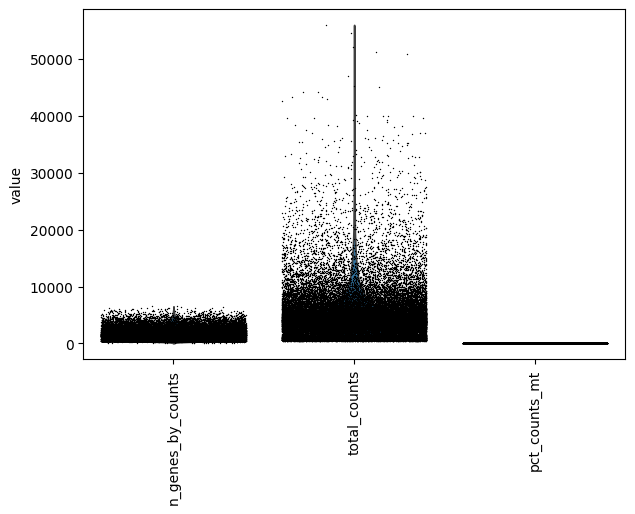

In [ ]:
sc.pl.violin(
    adata_sansfiltre,
    keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    groupby=None,  # ou "sample_id" si tu veux séparer par échantillon
    jitter=0.4,
    rotation=90
)

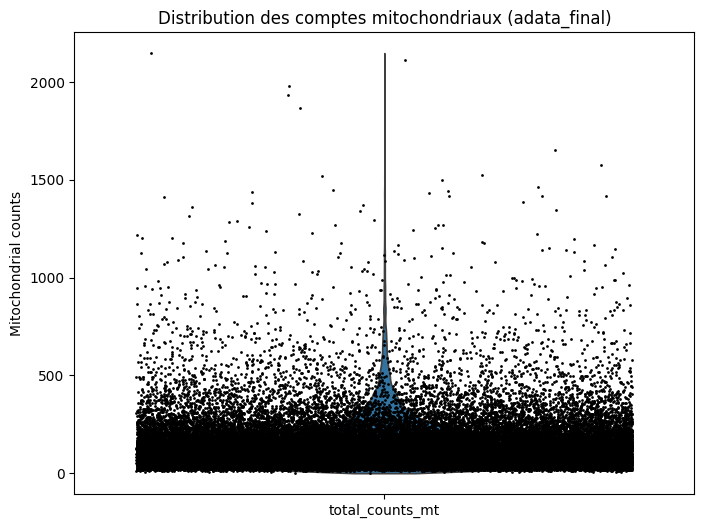

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

sc.pl.violin(
    adata_sansfiltre,
    keys=["total_counts_mt"],
    jitter=0.4,
    stripplot=True,
    size=2,
    ylabel="Mitochondrial counts",
    ax=ax,
    show=False
)

ax.set_title("Distribution des comptes mitochondriaux (adata_final)")
plt.show()


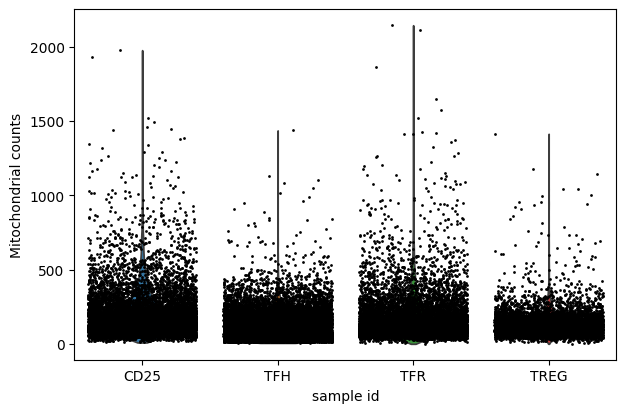

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

# Tracer un violon plot pour le total des comptes mitochondriaux par échantillon
sc.pl.violin(
    adata_sansfiltre,
    keys=["total_counts_mt"],
    groupby="sample_id",  # ou un autre groupe si besoin
    jitter=0.4,
    stripplot=True,
    size=2,
    ylabel="Mitochondrial counts",
)
plt.show()


**Chargement des données avec filtrage (par échantillon)\/ Fusion des matrices de différents échantillons**

In [ ]:
def charge_fichiers(prefixe):
    path = "/content/data/"
    fichier_mtx = f"{path}{prefixe}_matrix.mtx.gz"
    fichier_features = f"{path}{prefixe}_features.tsv.gz"
    fichier_barcodes = f"{path}{prefixe}_barcodes.tsv.gz"

    try:
        adata = sc.read_mtx(fichier_mtx).T
        genes = pd.read_csv(fichier_features, header=None, sep='\t')
        cells = pd.read_csv(fichier_barcodes, header=None, sep='\t')

        # Utilisation de la deuxième colonne pour les symboles de gènes
        adata.var_names = genes[1].values
        adata.var_names_make_unique()  # S'assurer que les noms de gènes sont uniques
        adata.obs_names = cells[0].values
        # Rendre les noms de cellules uniques pour éviter les erreurs
        adata.obs_names_make_unique()

        # Identification des gènes mitochondriaux avec le préfixe "MT-"
        adata.var["mt"] = adata.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, inplace=True)

        # Filtrage des cellules selon les critères QC
        adata = adata[(adata.obs["n_genes_by_counts"] > 200) &
                      (adata.obs["n_genes_by_counts"] < 2500) &
                      (adata.obs["pct_counts_mt"] < 15), :]
        print(adata)
        print(adata.shape)

        return adata
    except Exception as e:
        print(f"Erreur: {e}")
        return None

In [ ]:
matrice_tfh = charge_fichiers("GSM6612128_TC174_TFH_5GEX")
matrice_tfr = charge_fichiers("GSM6612132_TC174_TFR_5GEX")
matrice_treg = charge_fichiers("GSM6612134_TC174_TREG_5GEX")
matrice_cd25 = charge_fichiers("GSM6612130_TC174_CD25hiTfh_5GEX")

View of AnnData object with n_obs × n_vars = 14867 × 33677
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
(14867, 33677)
View of AnnData object with n_obs × n_vars = 8263 × 33677
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
(8263, 33677)
View of AnnData object with n_obs × n_vars = 8893 × 33677
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_

In [ ]:
def assembler_matrices(matrices, noms_samples):
    if len(matrices) != len(noms_samples):
        raise ValueError("Les matrices et les noms doivent être de même longueur.")

    for i, adata in enumerate(matrices):
        adata.obs["sample_id"] = noms_samples[i]

    return sc.concat(matrices, join="inner")


In [ ]:
adata_final = assembler_matrices(
    [matrice_tfh, matrice_tfr, matrice_treg, matrice_cd25],
    ["TFH", "TFR", "TREG", "CD25"]
)

print(adata_final.obs["sample_id"].value_counts())

sample_id
TFH     14867
TREG     8893
TFR      8263
CD25     6461
Name: count, dtype: int64


**Graphes en violon : Vérifier l’effet du filtrage sur les gènes mitochondriaux**

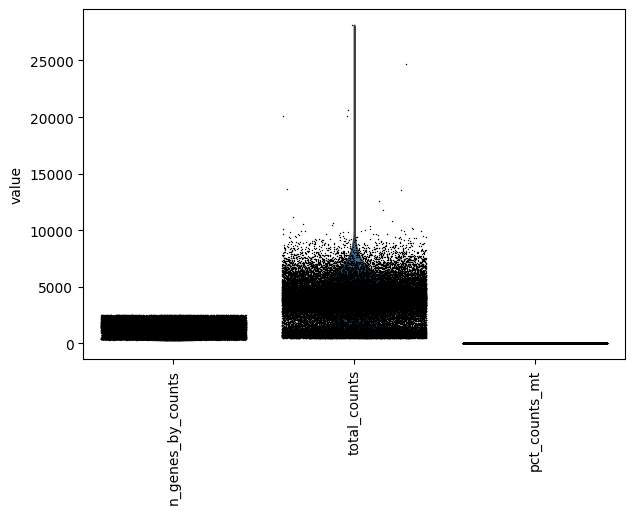

In [ ]:
import scanpy as sc

sc.pl.violin(
    adata_final,
    keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    groupby=None,  # ou "sample_id" si tu veux séparer par échantillon
    jitter=0.4,
    rotation=90
)


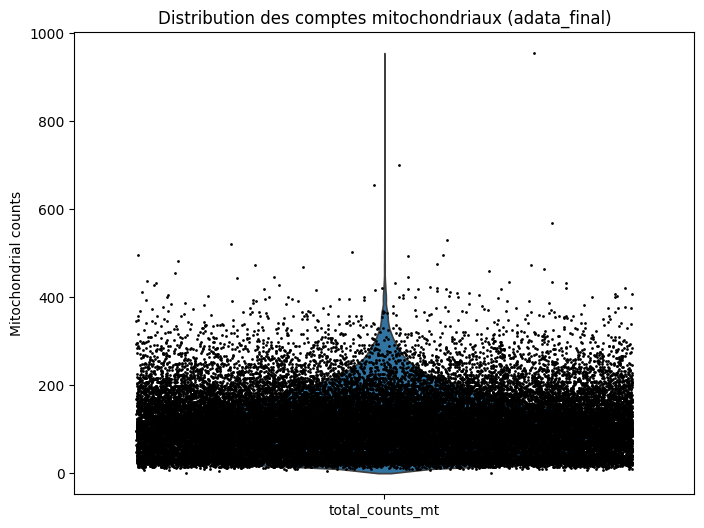

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

sc.pl.violin(
    adata_final,
    keys=["total_counts_mt"],
    jitter=0.4,
    stripplot=True,
    size=2,
    ylabel="Mitochondrial counts",
    ax=ax,
    show=False
)

ax.set_title("Distribution des comptes mitochondriaux (adata_final)")
plt.show()


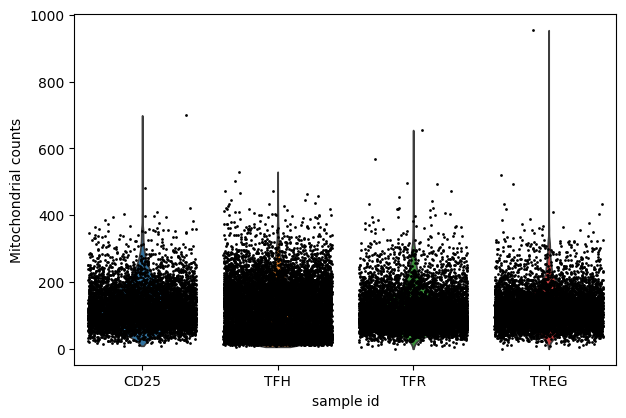

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

# Tracer un violon plot pour le total des comptes mitochondriaux par échantillon
sc.pl.violin(
    adata_final,
    keys=["total_counts_mt"],
    groupby="sample_id",  # ou un autre groupe si besoin
    jitter=0.4,
    stripplot=True,
    size=2,
    ylabel="Mitochondrial counts",
)
plt.show()


**Analyse de l’expression des marqueurs clés dans populations callullaires (CXCR5, FOXP3,PDCD1,MKI67,IL1R1,IL1R2) par violin plots**

In [ ]:
def plot_violin_plots(adata, genes, group_by="sample_id", palette="muted", figsize=(18, 10), log_transform=False):

    df_violin = adata.obs.copy()
    n_rows = (len(genes) + 2) // 3
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten()

    for i, gene in enumerate(genes):
        expression = adata[:, gene].X.toarray().flatten()
        if log_transform:
            expression = np.log1p(expression)
        df_violin["Expression"] = expression

        ax = axes[i]
        sns.violinplot(x=group_by, y="Expression", hue=group_by,
                       data=df_violin, palette=palette, legend=False, ax=ax)

        ax.set_title(f"Expression de {gene}", fontsize=12, fontweight="bold")
        ax.set_xlabel(group_by)
        ax.set_ylabel("Log(Expression + 1)" if log_transform else "Expression")
        ax.tick_params(axis='x', rotation=45)

    for j in range(len(genes), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



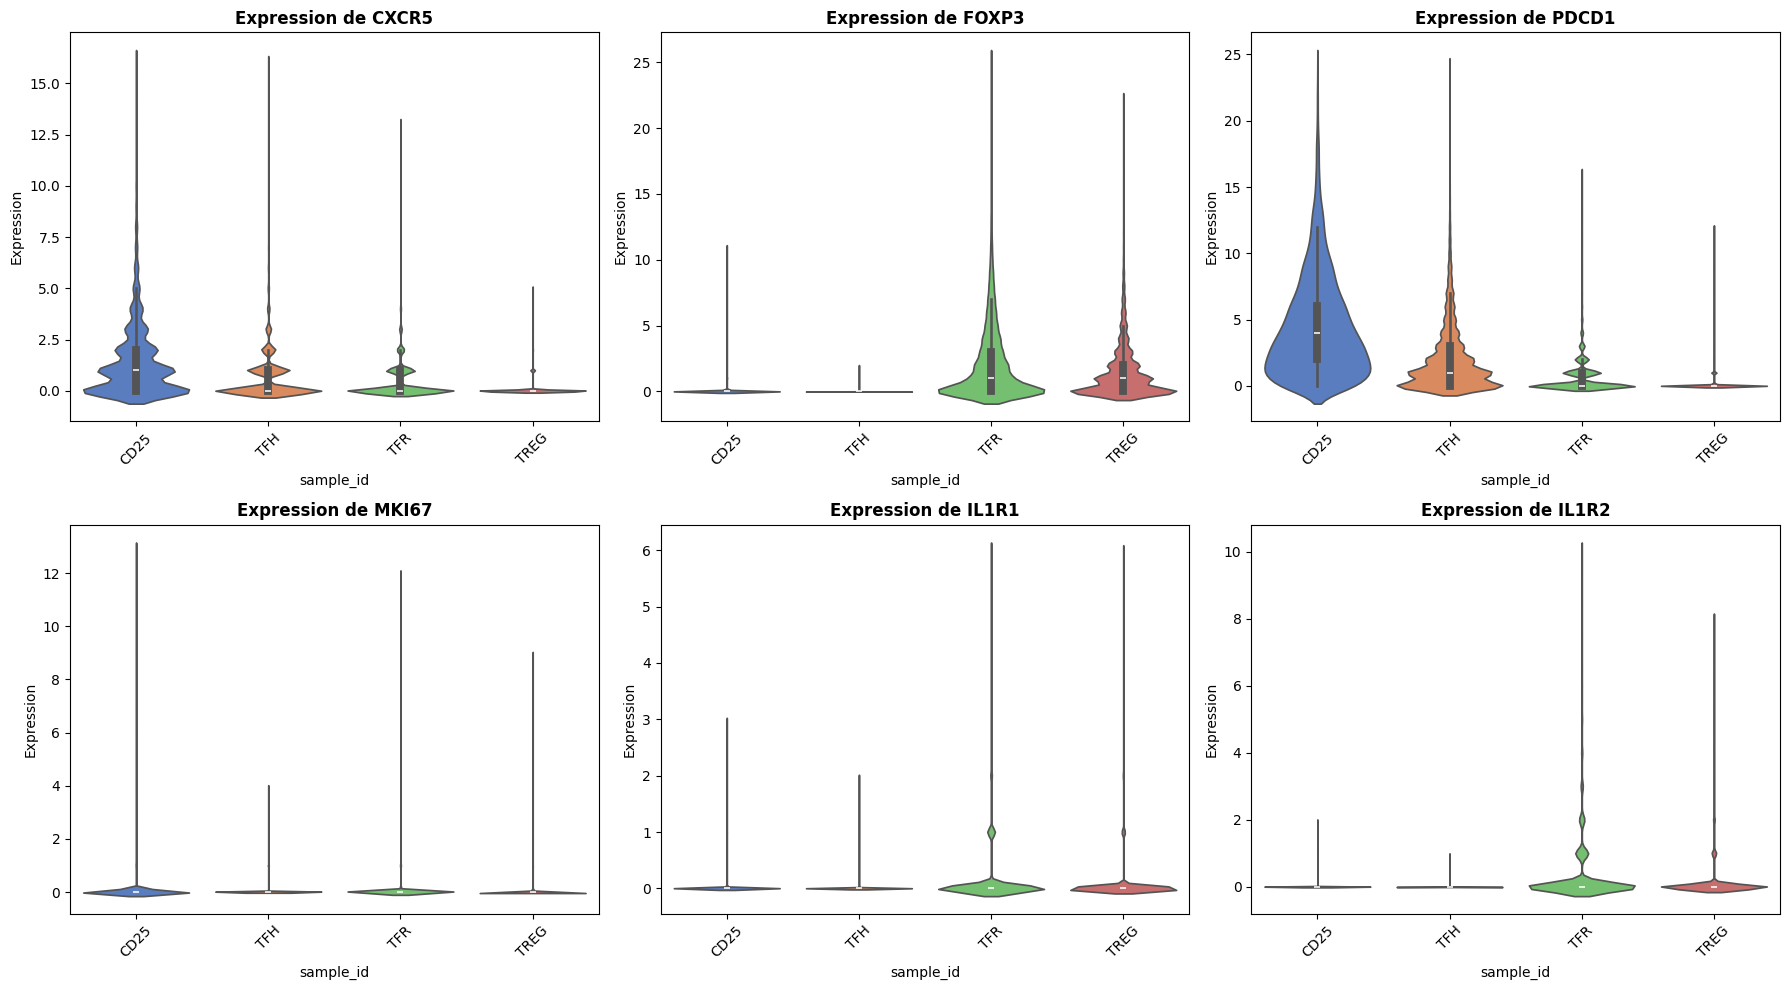

In [ ]:
genes_of_interest = ["CXCR5", "FOXP3", "PDCD1", "MKI67", "IL1R1", "IL1R2"]
plot_violin_plots(adata_final, genes_of_interest)

**Représentation moyenne de l’expression génique par type cellulaire par heatmaps**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_gene_expression_heatmap(adata, genes, group_by="sample_id", cmap="RdYlGn_r", figsize=(10, 6), annot=True):

    heatmap_data = {}

    for gene in genes:
        heatmap_data[gene] = adata[:, gene].X.toarray().flatten()

    df_heatmap = pd.DataFrame(heatmap_data, index=adata.obs_names)
    df_heatmap[group_by] = adata.obs[group_by].values

    # Moyenne d'expression génique par groupe
    df_grouped = df_heatmap.groupby(group_by, observed=False).mean()

    plt.figure(figsize=figsize)
    sns.heatmap(df_grouped, cmap=cmap, annot=annot, fmt=".2f")
    plt.title("Expression moyenne des gènes par type cellulaire", fontsize=14, fontweight="bold")
    plt.xlabel("Gènes")
    plt.ylabel("Type cellulaire")
    plt.tight_layout()
    plt.show()


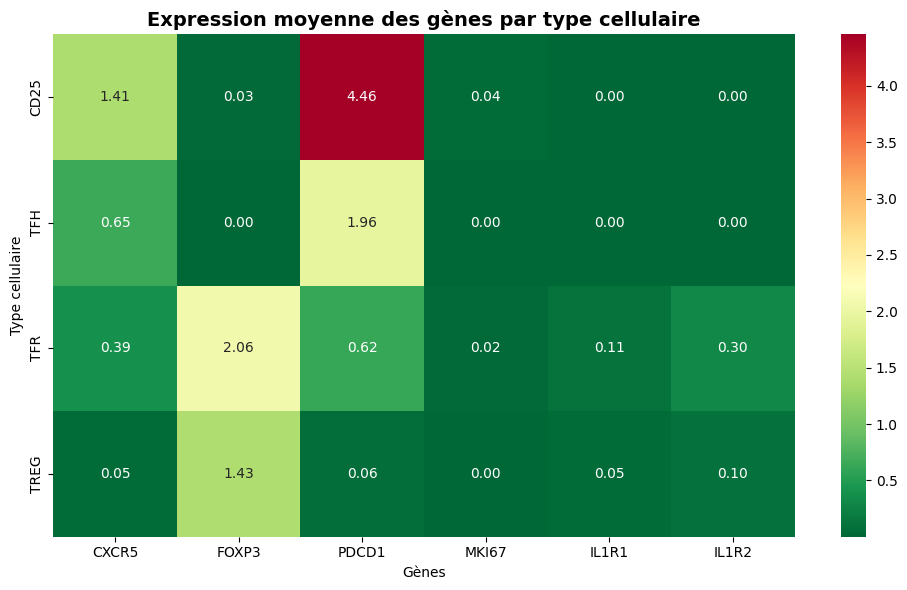

In [ ]:
plot_gene_expression_heatmap(adata_final, genes_of_interest)

**Analyse en composantes principales (PCA) pour la réduction de dimension**

In [ ]:
sc.pp.normalize_total(adata_final, target_sum=1e4)
sc.pp.log1p(adata_final)

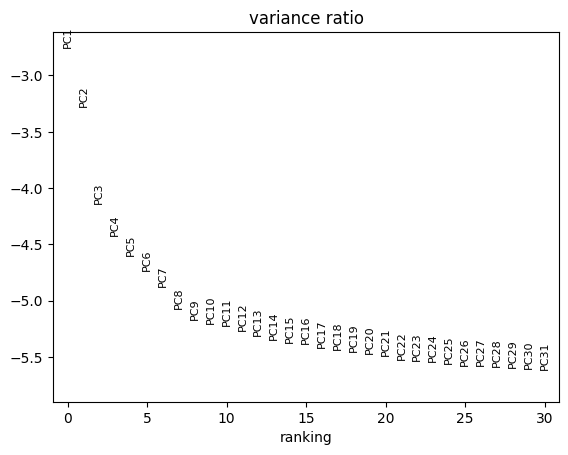

In [ ]:
sc.pp.highly_variable_genes(adata_final, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata_final[:, adata_final.var.highly_variable]
sc.pp.pca(adata, n_comps=50)
sc.pl.pca_variance_ratio(adata, log=True)

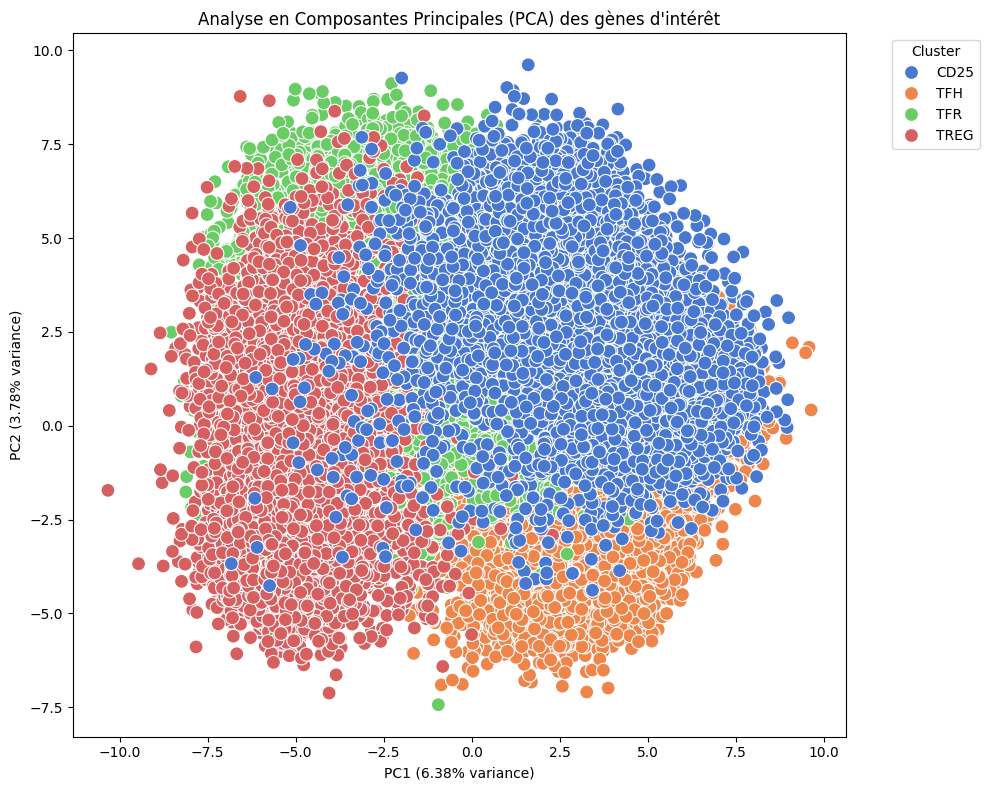

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc

# Assuming 'adata' is the AnnData object after PCA
pca_result = adata.obsm['X_pca'][:, :2]  # Get the first 2 PCs

df_pca = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
df_pca["Cluster"] = adata.obs["sample_id"].values  # Add cluster information

# Calculate PCA variance ratio before plotting
# Perform PCA and get the info, setting copy=True to return the result
#pca_info = sc.pp.pca(adata, n_comps=50, return_info=True, copy=True) # This line is causing the error.

# Access variance ratio from adata.uns, where it is stored after running sc.pp.pca
variance_ratio = adata.uns['pca']['variance_ratio']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Cluster", palette="muted", s=100, edgecolor="white")
plt.title("Analyse en Composantes Principales (PCA) des gènes d'intérêt")

# Access variance ratio directly
plt.xlabel(f"PC1 ({variance_ratio[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({variance_ratio[1]*100:.2f}% variance)")

plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Visualisation des sous-populations cellulaires avec UMAP  pour explorer lrépartition des différents types cellulaires et l’expression des gènes marqueurs**

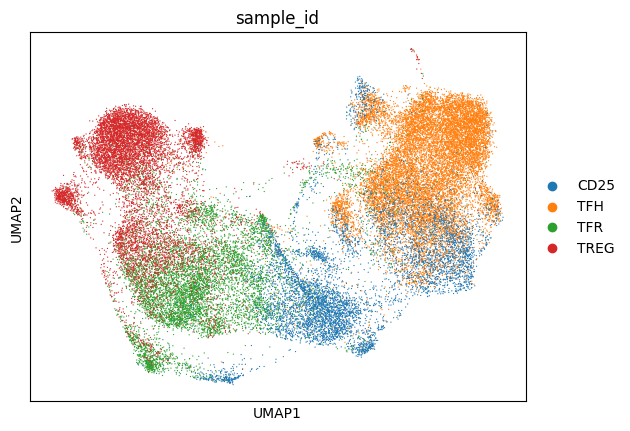

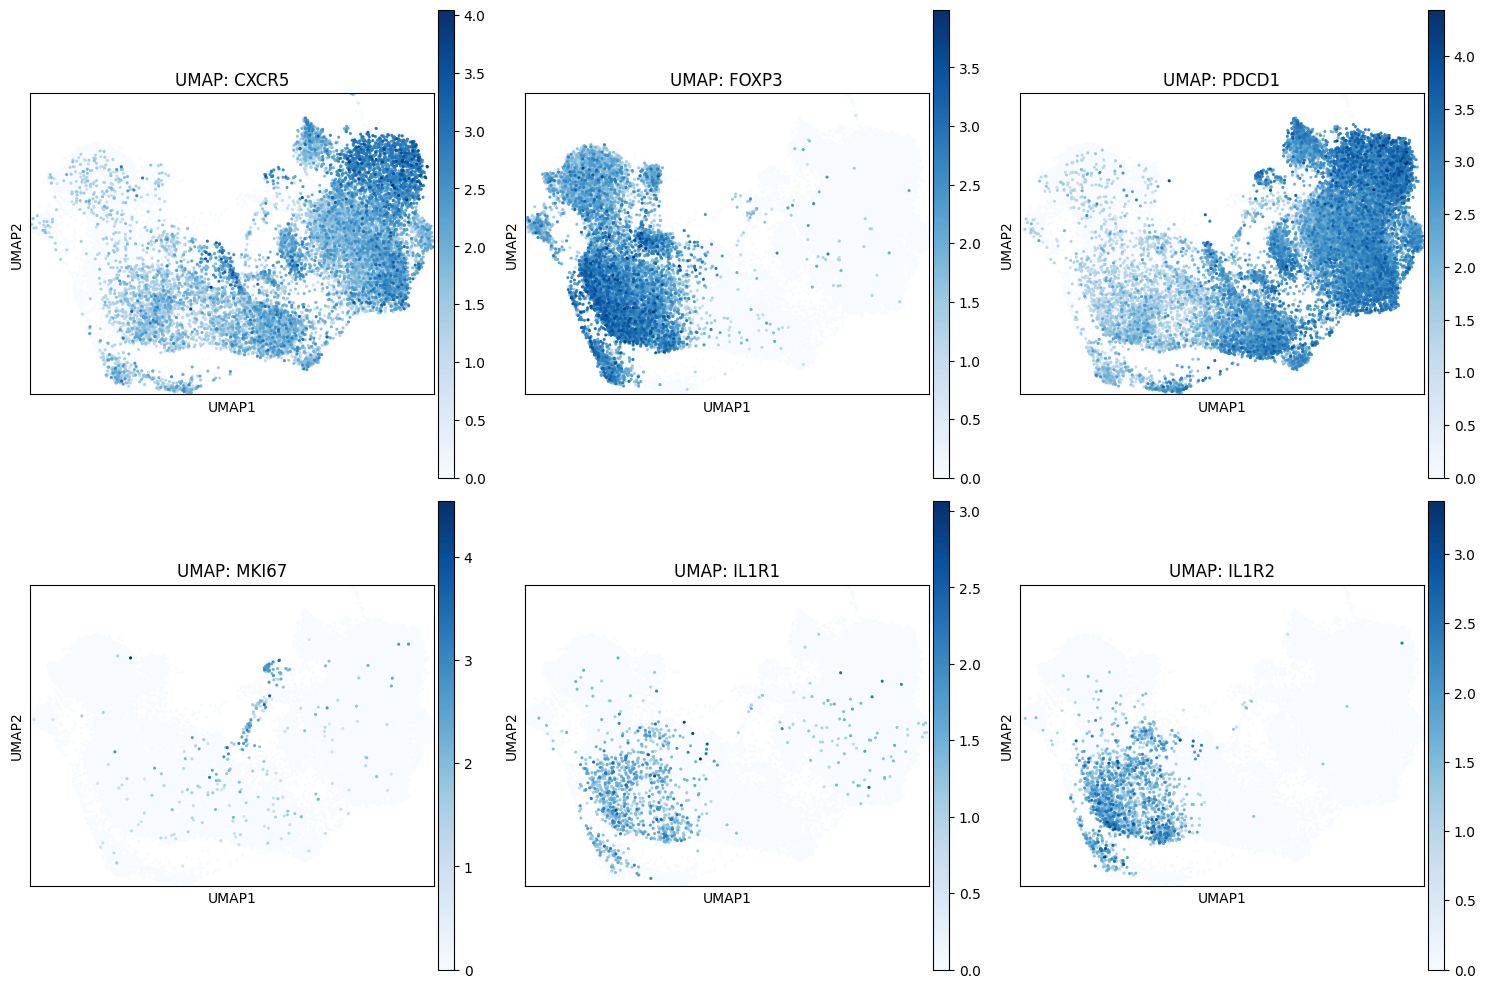

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc


# Liste des gènes à visualisersous clusters de cellules
genes_to_plot = ["CXCR5", "FOXP3", "PDCD1", "MKI67", "IL1R1", "IL1R2"]

def plot_umap(adata, genes, title_prefix="UMAP"):
    """
    Génère des UMAPs de mêmes dimensions pour comparer les groupes.

    Paramètres :
    - adata : AnnData object contenant les données RNA-seq
    - genes : Liste des gènes à visualiser
    - title_prefix : Préfixe pour le titre des graphiques

    Retour :
    - Affichage des UMAPs avec la même taille et échelle
    """
    # Prétraitement UMAP
    sc.pp.pca(adata, n_comps=min(50, adata.shape[1] - 1))  # Évite les erreurs PCA
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=min(30, adata.shape[1] - 1))  # Recalcule le graphe des voisins
    sc.tl.umap(adata, min_dist=0.3, spread=1.0)

    # Vérifier la structure des échantillons
    sc.pl.umap(adata, color="sample_id")

    # Définition des limites des axes pour uniformiser les UMAPs
    x_min, x_max = adata.obsm["X_umap"][:, 0].min(), adata.obsm["X_umap"][:, 0].max()
    y_min, y_max = adata.obsm["X_umap"][:, 1].min(), adata.obsm["X_umap"][:, 1].max()

    # Taille fixe pour toutes les figures
    figsize_per_plot = (5, 5)  # Taille identique pour chaque UMAP
    n_genes = len(genes)
    n_cols = 3  # Nombre de colonnes fixes
    n_rows = -(-n_genes // n_cols)  # Arrondi vers le haut pour le nombre de lignes

    # Création de la figure principale avec des sous-graphiques de taille uniforme
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()  # Transformer la grille en liste 1D

    for i, gene in enumerate(genes):
        sc.pl.umap(adata, color=gene, ax=axes[i], show=False, cmap="Blues", size=20)
        axes[i].set_title(f"{title_prefix}: {gene}")
        axes[i].set_xlim(x_min, x_max)  # Fixer les limites X pour toutes les figures
        axes[i].set_ylim(y_min, y_max)  # Fixer les limites Y pour toutes les figures
        axes[i].set_aspect('equal')  # Forcer un rapport d’aspect carré

    # Cacher les axes vides si nécessaire
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()  # Ajuster l'espacement entre les graphes
    plt.show()

# Appel de la fonction
plot_umap(adata_final, genes_to_plot, title_prefix="UMAP")

**Détection automatique des sous-populations avec le clustering Louvain**

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import igraph as i

def optimize_louvain_resolution(adata, genes_interet, resolutions=np.arange(0.1, 2.0, 0.1)):
    """
    Trouve la meilleure résolution Louvain en testant plusieurs valeurs et en mesurant la modularité.
    """
    modularities = []

    for res in resolutions:
        adata_subset = adata[:, genes_interet].copy()
        adata_subset.obs_names_make_unique()

        sc.pp.scale(adata_subset)
        n_pcs = min(adata_subset.shape[0] - 1, adata_subset.shape[1] - 1, 3)
        sc.pp.pca(adata_subset, n_comps=n_pcs)
        sc.pp.neighbors(adata_subset, n_neighbors=15, n_pcs=30)

        sc.tl.louvain(adata_subset, resolution=res)

        g = sc._utils.get_igraph_from_adjacency(adata_subset.obsp["connectivities"], directed=False)
        clustering = list(map(int, adata_subset.obs["louvain"]))
        modularity = g.modularity(clustering)
        modularities.append(modularity)

    best_resolution = resolutions[np.argmax(modularities)]

    plt.figure(figsize=(8, 5))
    plt.plot(resolutions, modularities, marker="o", linestyle="-", color="b")
    plt.xlabel("Résolution")
    plt.ylabel("Modularité")
    plt.title("Optimisation de la résolution Louvain")
    plt.grid(True)
    plt.show()

    print(f"Meilleure résolution trouvée : {best_resolution}")
    return best_resolution

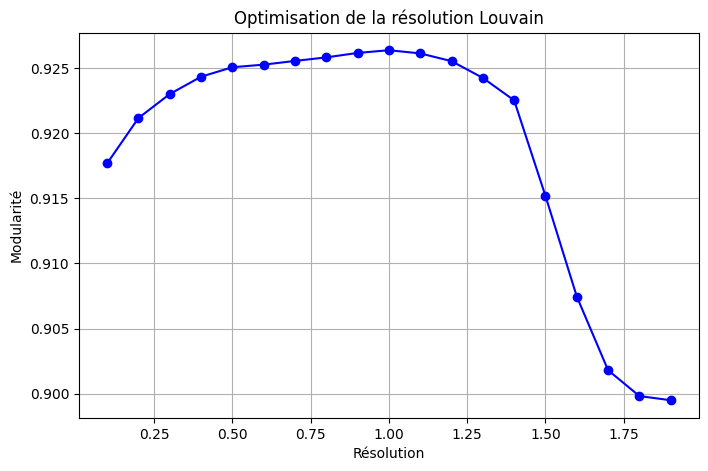

Meilleure résolution trouvée : 1.0


In [ ]:
best_res = optimize_louvain_resolution(adata_final, genes_to_plot)

In [ ]:
sc.tl.louvain(adata_final, resolution=2.10)
print(adata_final.obs["louvain"].value_counts())

louvain
0     4486
1     3127
2     2750
3     2458
4     2411
5     2256
6     2247
7     2184
8     2003
9     1897
10    1578
11    1438
12    1224
13    1169
14    1048
15    1043
16     924
17     832
18     688
19     620
20     599
21     536
22     370
23     330
24     240
25      26
Name: count, dtype: int64


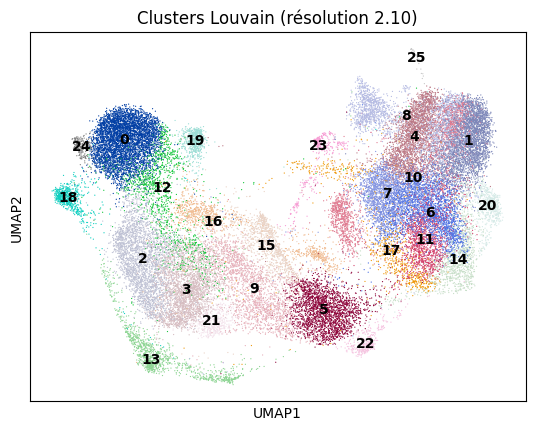

In [ ]:
sc.pl.umap(adata_final, color="louvain", title="Clusters Louvain (résolution 2.10)", legend_loc="on data")


**Visualisation des gènes d’intérêt (log transformés) dans chaque cluster
Ces graphes permettent de repérer les clusters où les marqueurs sont fortement exprimés.**

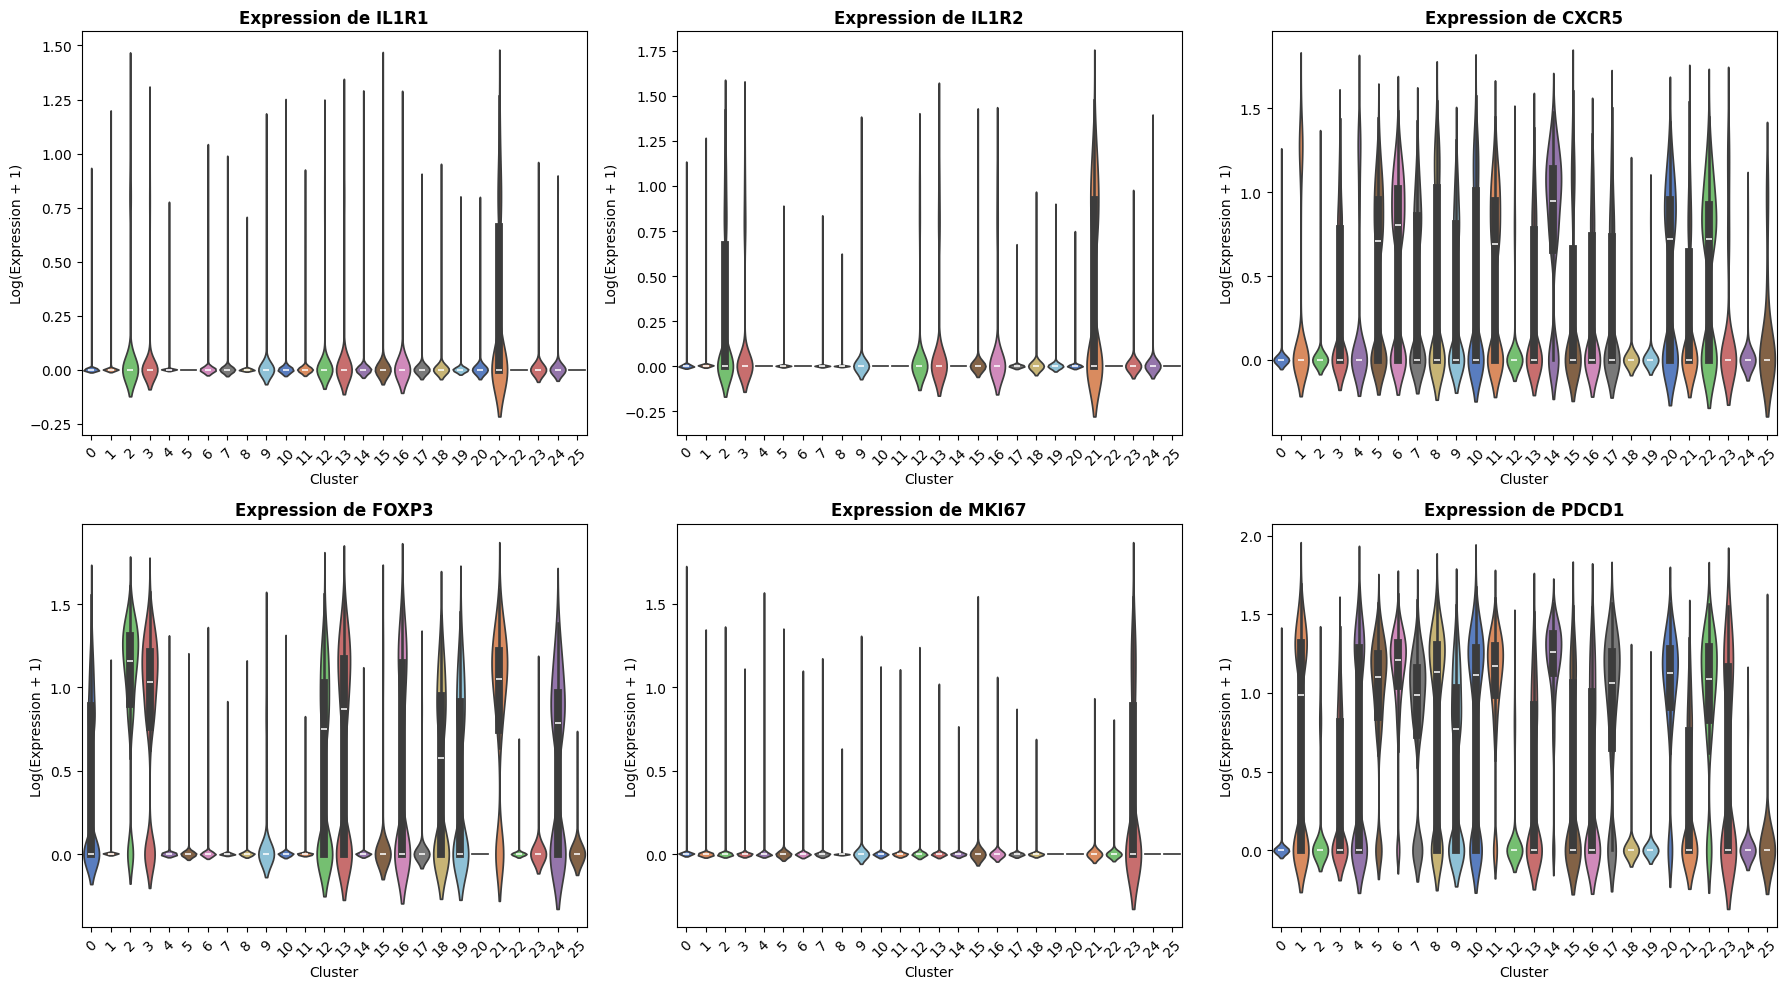

In [ ]:
sc.tl.louvain(adata_final, resolution=2.10)
adata_final.obs["Cluster"] = adata_final.obs["louvain"]
genes_to_plot = ['IL1R1', 'IL1R2', 'CXCR5', 'FOXP3', 'MKI67', 'PDCD1']
plot_violin_plots(adata_final, genes_to_plot, group_by="Cluster", log_transform=True)


**Carte de chaleur de l’expression moyenne des gènes dans chaque cluster**

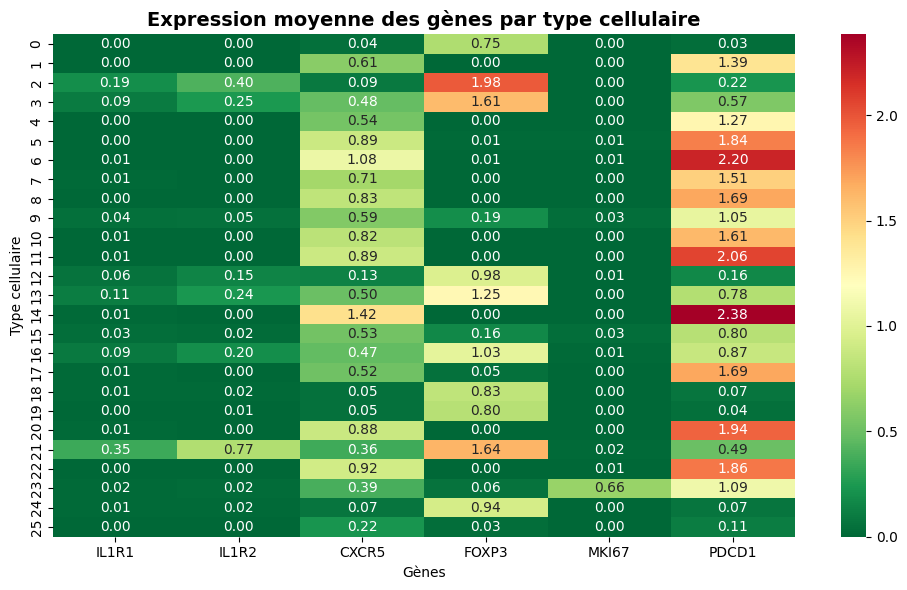

In [ ]:
plot_gene_expression_heatmap(adata_final, genes_to_plot, group_by="louvain")

**Visualisation de l’expression des gènes d’intérêt immunitaire (DotPlot & Violin plots - Scanpy)**

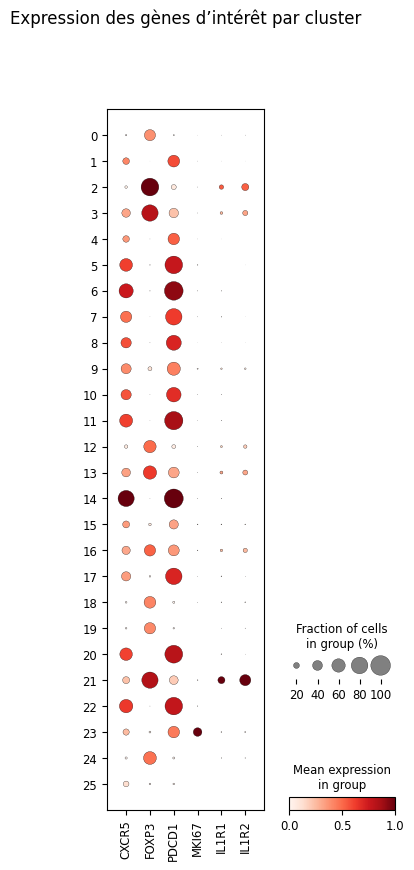

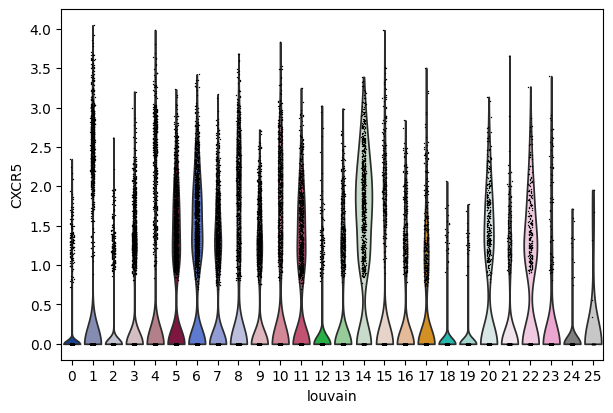

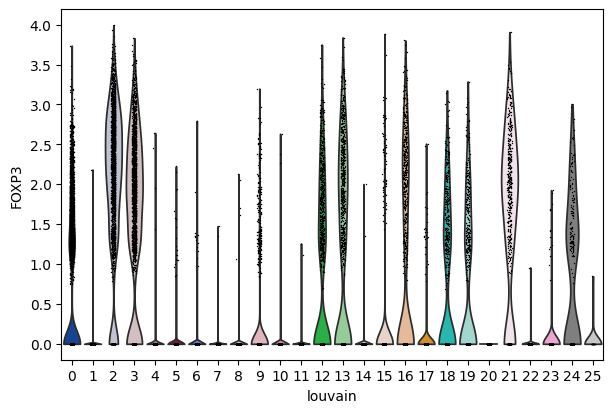

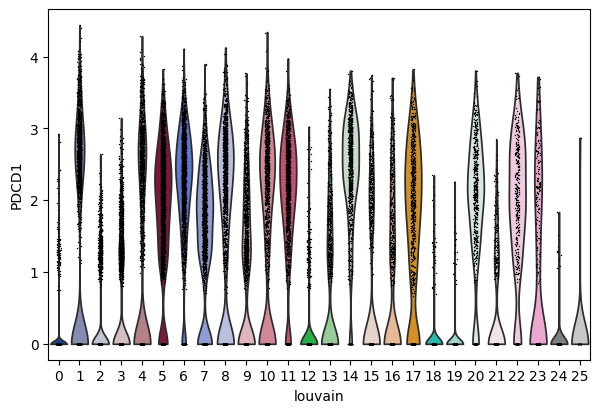

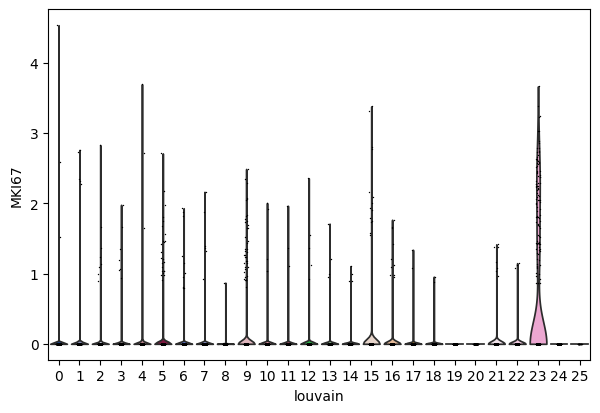

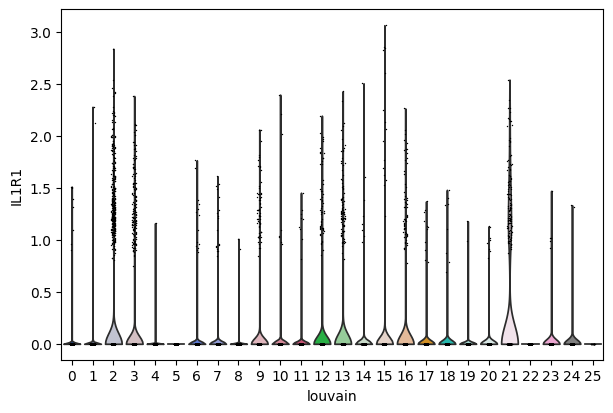

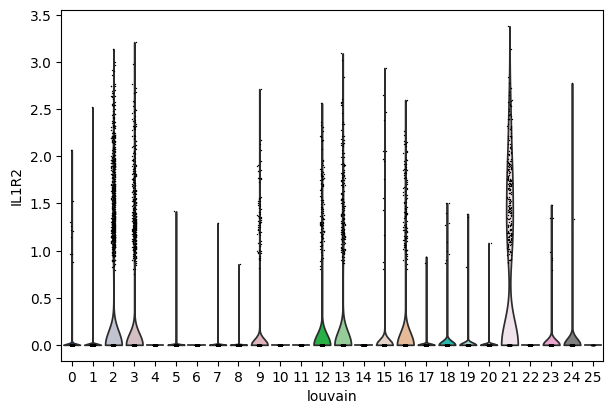

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

# Liste des gènes d’intérêt (modifiable si besoin)
genes_of_interest = ["CXCR5", "FOXP3", "PDCD1", "MKI67", "IL1R1", "IL1R2"]

# --- 1. Dotplot : Expression moyenne + fraction de cellules exprimant chaque gène par cluster ---
sc.pl.dotplot(
    adata_final,
    var_names=genes_of_interest,
    groupby="louvain",
    standard_scale='var',
    title="Expression des gènes d’intérêt par cluster",
    show=True
)

# --- 2. Violin plots : Distribution de l'expression par gène et par cluster ---
for gene in genes_of_interest:
    sc.pl.violin(
        adata_final,
        keys=gene,
        groupby="louvain",
        jitter=True,
        stripplot=True,
        show=True
    )

**Vèrification de conditions d'applications de test ANOVA (normalité)**

In [ ]:
noms_samples = ["TFH", "TFR", "TREG", "CD25"]
adata_all = assembler_matrices([matrice_tfh, matrice_tfr, matrice_treg, matrice_cd25], noms_samples)
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)

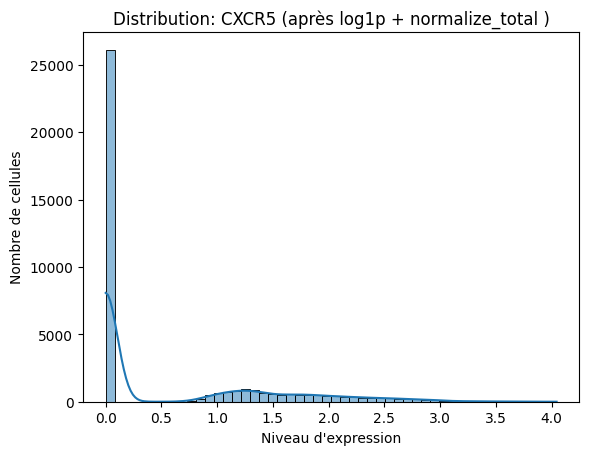

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

expr = adata_all[:, "CXCR5"].X.toarray().flatten()

sns.histplot(expr, kde=True, bins=50)
plt.title("Distribution: CXCR5 (après log1p + normalize_total )")
plt.xlabel("Niveau d'expression")
plt.ylabel("Nombre de cellules")
plt.show()

In [ ]:
from scipy.stats import shapiro
import numpy as np

expr = expr[~np.isnan(expr)]
if len(expr) > 5000:
    expr = np.random.choice(expr, 5000, replace=False)

stat, p = shapiro(expr)
print(f"Shapiro p-value (CXCR5): {p}")

Shapiro p-value (CXCR5): 4.929560808271611e-71


In [ ]:
from scipy.stats import shapiro
import numpy as np
import pandas as pd
import scanpy as sc

samples = ["TFH", "TFR", "TREG", "CD25"]
genes_of_interest = ["CXCR5", "FOXP3", "PDCD1", "MKI67", "IL1R1", "IL1R2"]

results = []

for gene in genes_of_interest:
    if gene in adata_all.var_names:
        for sample in samples:
            expr = adata_all[adata_all.obs["sample_id"] == sample, gene].X
            if hasattr(expr, "toarray"):
                expr = expr.toarray().flatten()
            else:
                expr = np.array(expr).flatten()

            expr = expr[~np.isnan(expr)]

            # Eğer hücre sayısı çok fazlaysa örnekle (max 5000 hücre)
            if len(expr) > 5000:
                expr = np.random.choice(expr, 5000, replace=False)

            if len(expr) >= 3:
                stat, p = shapiro(expr)
                results.append({
                    "Gene": gene,
                    "Sample": sample,
                    "Shapiro p-value": p
                })
            else:
                results.append({
                    "Gene": gene,
                    "Sample": sample,
                    "Shapiro p-value": None
                })
    else:
        print(f"Gene '{gene}' not found in data, skipping...")

# 3. Sonuçları tabloya dök
df_shapiro_grouped = pd.DataFrame(results)
print(df_shapiro_grouped)


     Gene Sample  Shapiro p-value
0   CXCR5    TFH     8.038092e-68
1   CXCR5    TFR     1.940182e-74
2   CXCR5   TREG     2.617063e-90
3   CXCR5   CD25     3.641543e-53
4   FOXP3    TFH     8.818914e-96
5   FOXP3    TFR     1.671526e-57
6   FOXP3   TREG     1.753153e-56
7   FOXP3   CD25     6.100645e-94
8   PDCD1    TFH     1.052051e-55
9   PDCD1    TFR     5.717540e-68
10  PDCD1   TREG     1.153251e-89
11  PDCD1   CD25     1.752788e-45
12  MKI67    TFH     2.075545e-95
13  MKI67    TFR     4.998683e-94
14  MKI67   TREG     1.034013e-95
15  MKI67   CD25     3.821227e-93
16  IL1R1    TFH     3.753628e-95
17  IL1R1    TFR     3.500096e-87
18  IL1R1   TREG     3.067378e-91
19  IL1R1   CD25     5.306344e-95
20  IL1R2    TFH     8.818914e-96
21  IL1R2    TFR     1.697720e-80
22  IL1R2   TREG     3.937459e-89
23  IL1R2   CD25     1.124125e-95


**Test non-paramètrique: Kruskal-Wallis parce que notre échantillon ne suit pas une distribution normale**




In [ ]:
from scipy.stats import kruskal
import pandas as pd
import numpy as np

def perform_kruskal_test(adata, genes_of_interest, samples, group_column="sample_id"):
    results = []

    for gene in genes_of_interest:
        if gene in adata.var_names:
            groups = []
            for sample in samples:
                expr = adata[adata.obs[group_column] == sample, gene].X
                if hasattr(expr, 'toarray'):
                    expr = expr.toarray().flatten()
                else:
                    expr = np.array(expr).flatten()
                expr = expr[~np.isnan(expr)]
                if len(expr) > 0:
                    groups.append(expr)

            if len(groups) >= 2:
                stat, p = kruskal(*groups)
                results.append({
                    "Gene": gene,
                    "Kruskal-Wallis stat": stat,
                    "p-value": p
                })

    return pd.DataFrame(results)

In [ ]:
df_kruskal = perform_kruskal_test(adata_final, ["CXCR5", "FOXP3", "PDCD1", "MKI67", "IL1R1", "IL1R2"], ["TFH", "TFR", "TREG", "CD25"])
print(df_kruskal)

    Gene  Kruskal-Wallis stat        p-value
0  CXCR5          5975.448656   0.000000e+00
1  FOXP3         15513.654604   0.000000e+00
2  PDCD1         14795.385562   0.000000e+00
3  MKI67           213.078413   6.292806e-46
4  IL1R1          1417.377188  4.993937e-307
5  IL1R2          3470.810773   0.000000e+00


In [ ]:
from scipy.stats import kruskal
import pandas as pd
import numpy as np

def kruskal_test_by_group(adata, genes_of_interest, groupby_column):
    results = []
    groups_list = adata.obs[groupby_column].unique()

    for gene in genes_of_interest:
        groups = []
        for group in groups_list:
            expr = adata[adata.obs[groupby_column] == group, gene].X
            if hasattr(expr, 'toarray'):
                expr = expr.toarray().flatten()
            else:
                expr = np.array(expr).flatten()
            expr = expr[~np.isnan(expr)]
            if len(expr) > 0:
                groups.append(expr)

        if len(groups) >= 2:
            stat, p = kruskal(*groups)
            results.append({
                "Gene": gene,
                "Kruskal-Wallis stat": stat,
                "p-value": p
            })

    return pd.DataFrame(results)


In [ ]:
df_kruskal_louvain = kruskal_test_by_group(adata_final, ["CXCR5", "FOXP3", "PDCD1", "MKI67", "IL1R1", "IL1R2"], "louvain")
print(df_kruskal_louvain)

    Gene  Kruskal-Wallis stat  p-value
0  CXCR5          7066.936551      0.0
1  FOXP3         20619.977960      0.0
2  PDCD1         14862.358695      0.0
3  MKI67          5116.977307      0.0
4  IL1R1          3129.658920      0.0
5  IL1R2          7072.653921      0.0


In [ ]:
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_dunn_heatmaps_for_genes(adata, genes, p_thresh=0.05, figsize=(14, 14)):
    for gene in genes:
        print(f" Analyse pour le gène : {gene}")


        df = adata.obs.copy()
        df["expression"] = adata[:, gene].X.toarray().flatten()

        # Dunn posthoc test
        dunn_result = sp.posthoc_dunn(df, val_col="expression", group_col="louvain", p_adjust="fdr_bh")


        mask = dunn_result < p_thresh
        display_values = dunn_result.where(mask, other=np.nan)


        plt.figure(figsize=figsize)
        sns.heatmap(display_values, annot=True, fmt=".2g", cmap="Reds", cbar=True,
                    linewidths=0.5, linecolor='gray')
        plt.title(f"Post-hoc Dunn test pour {gene} (seulement p < {p_thresh})")
        plt.xlabel("Cluster")
        plt.ylabel("Cluster")
        plt.tight_layout()
        plt.show()

 Analyse pour le gène : CXCR5


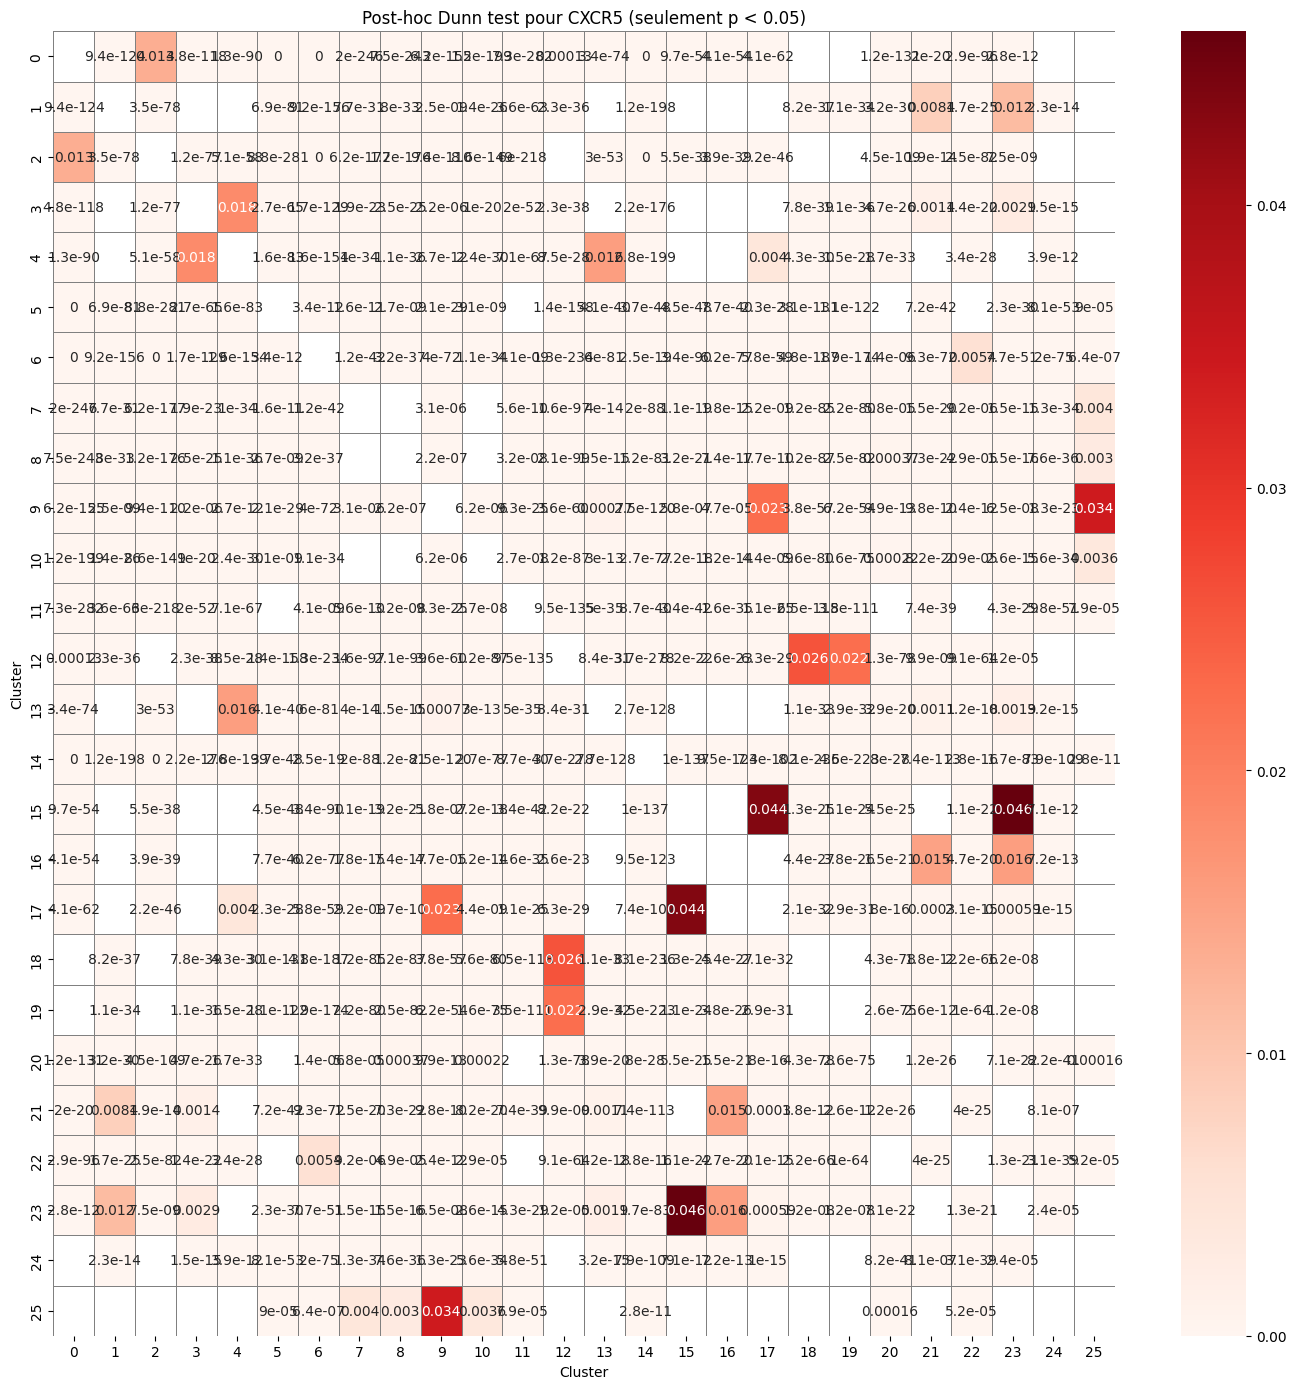

 Analyse pour le gène : FOXP3


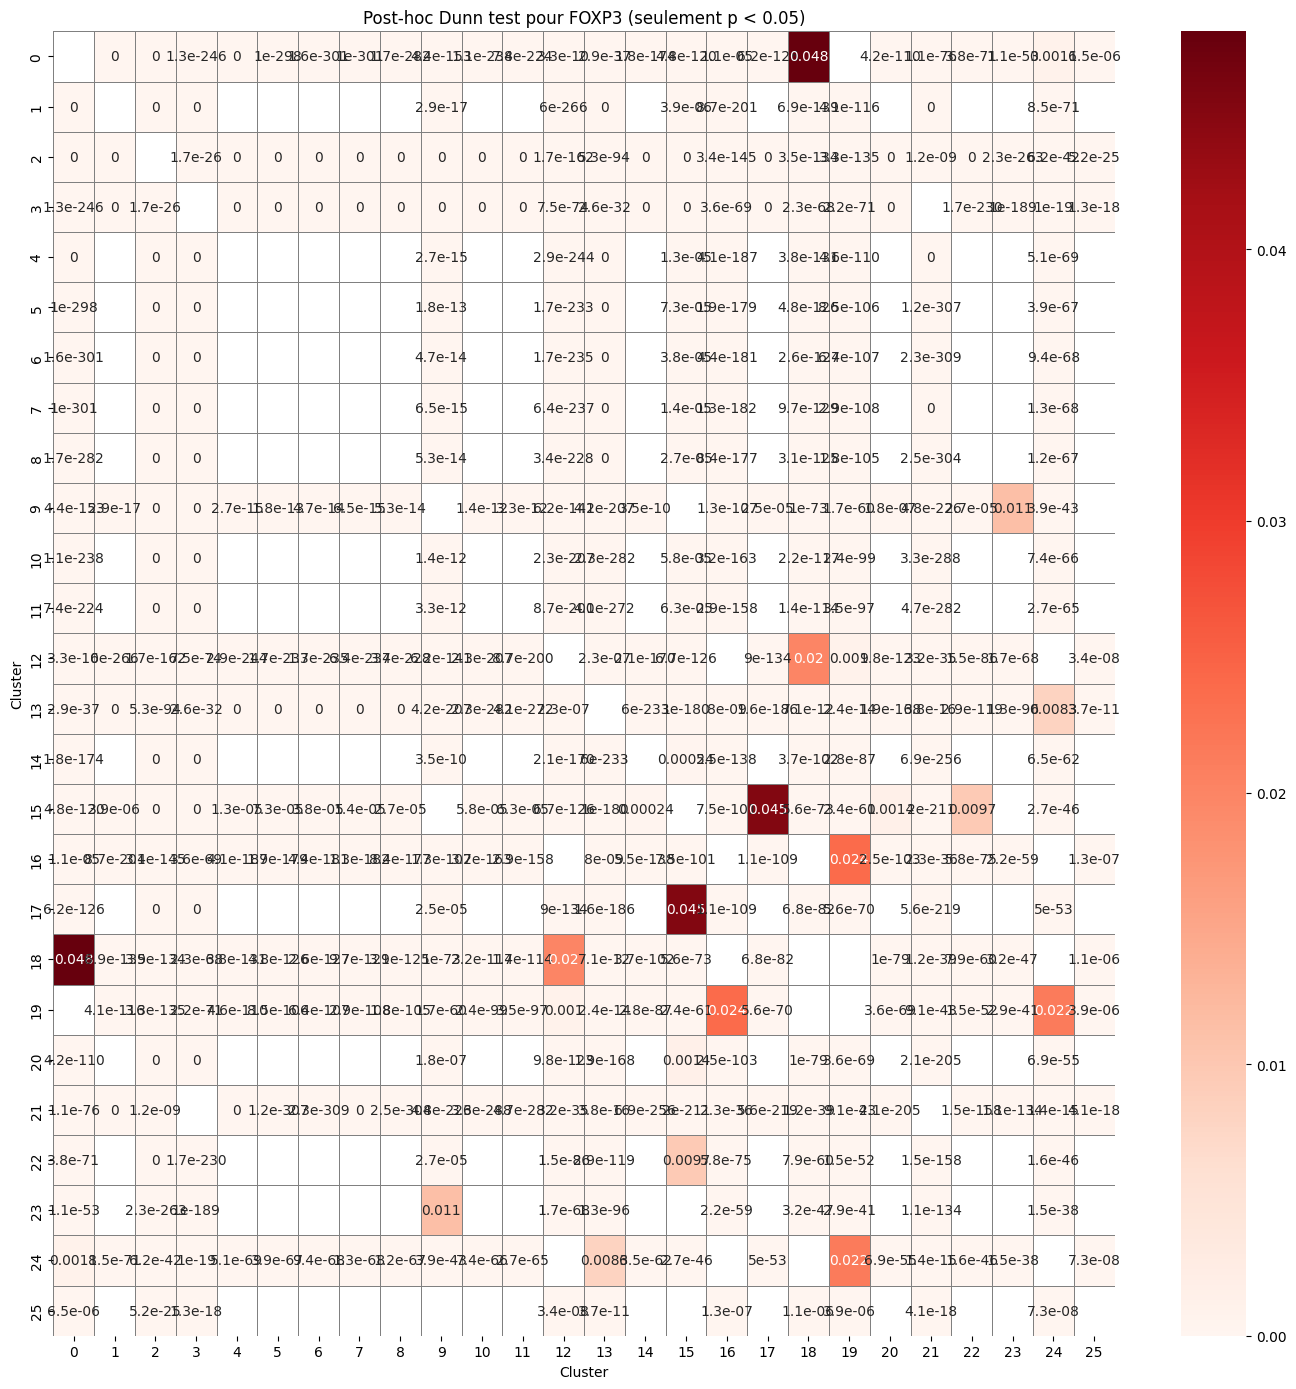

 Analyse pour le gène : PDCD1


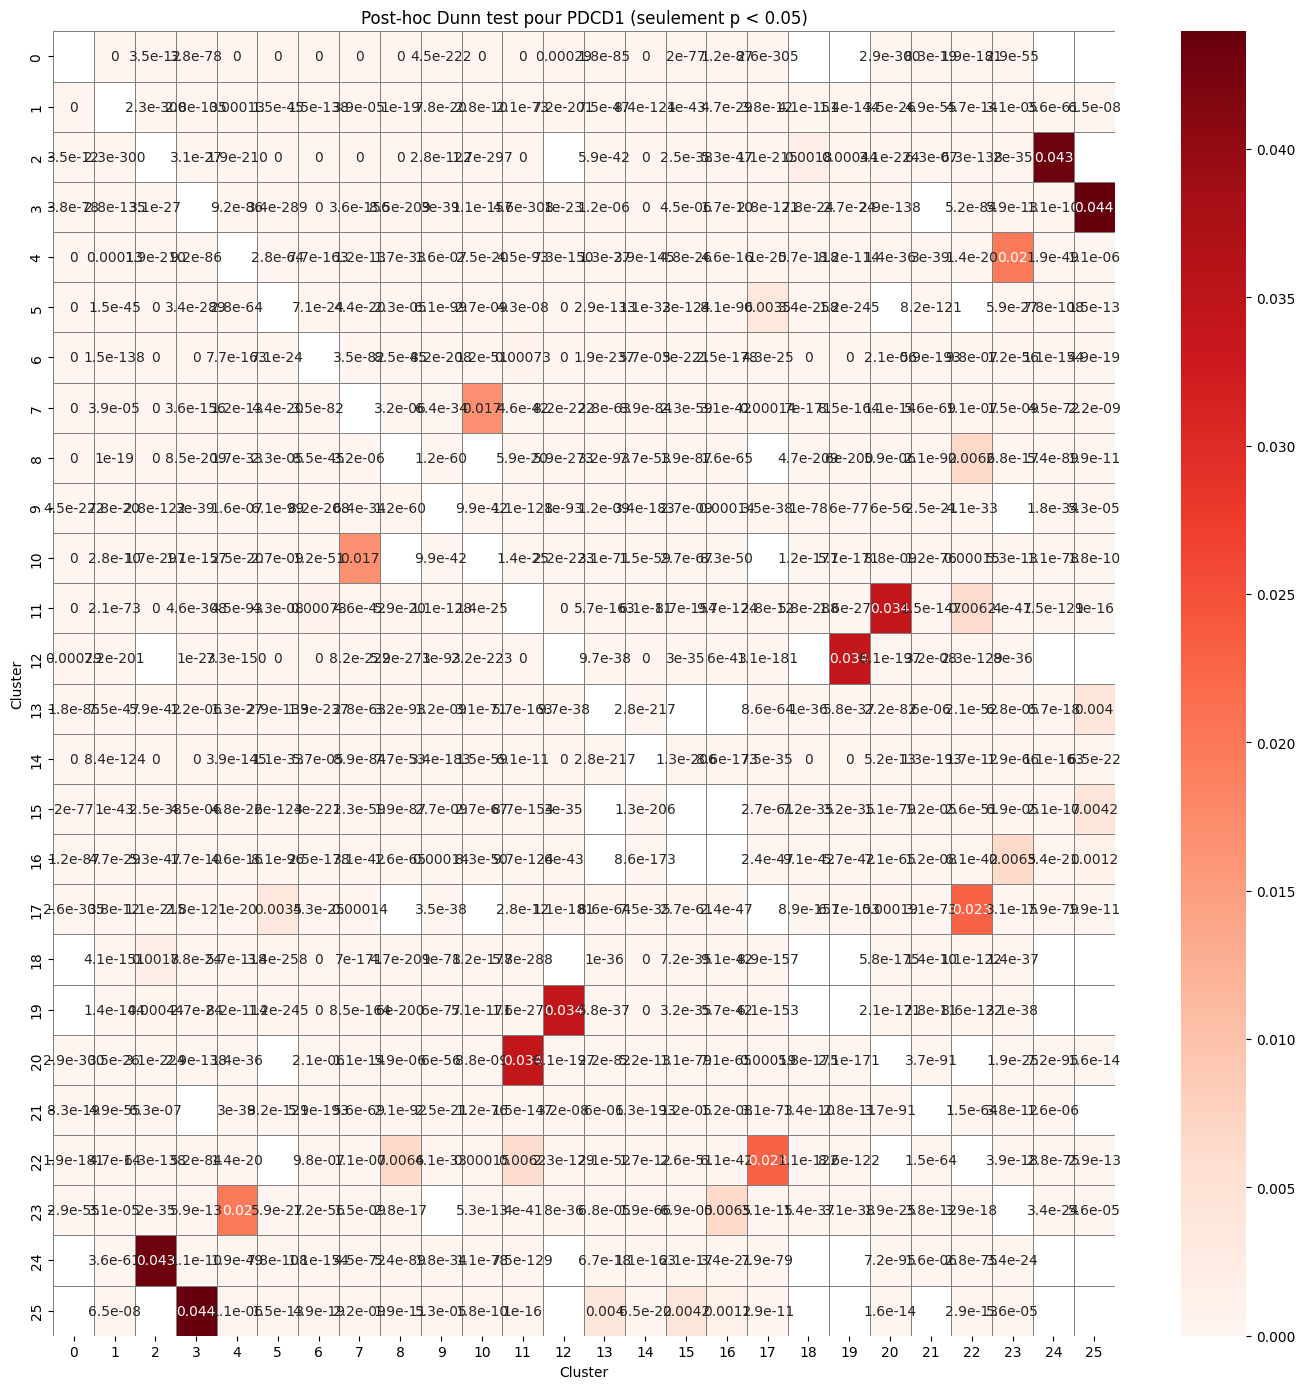

 Analyse pour le gène : MKI67


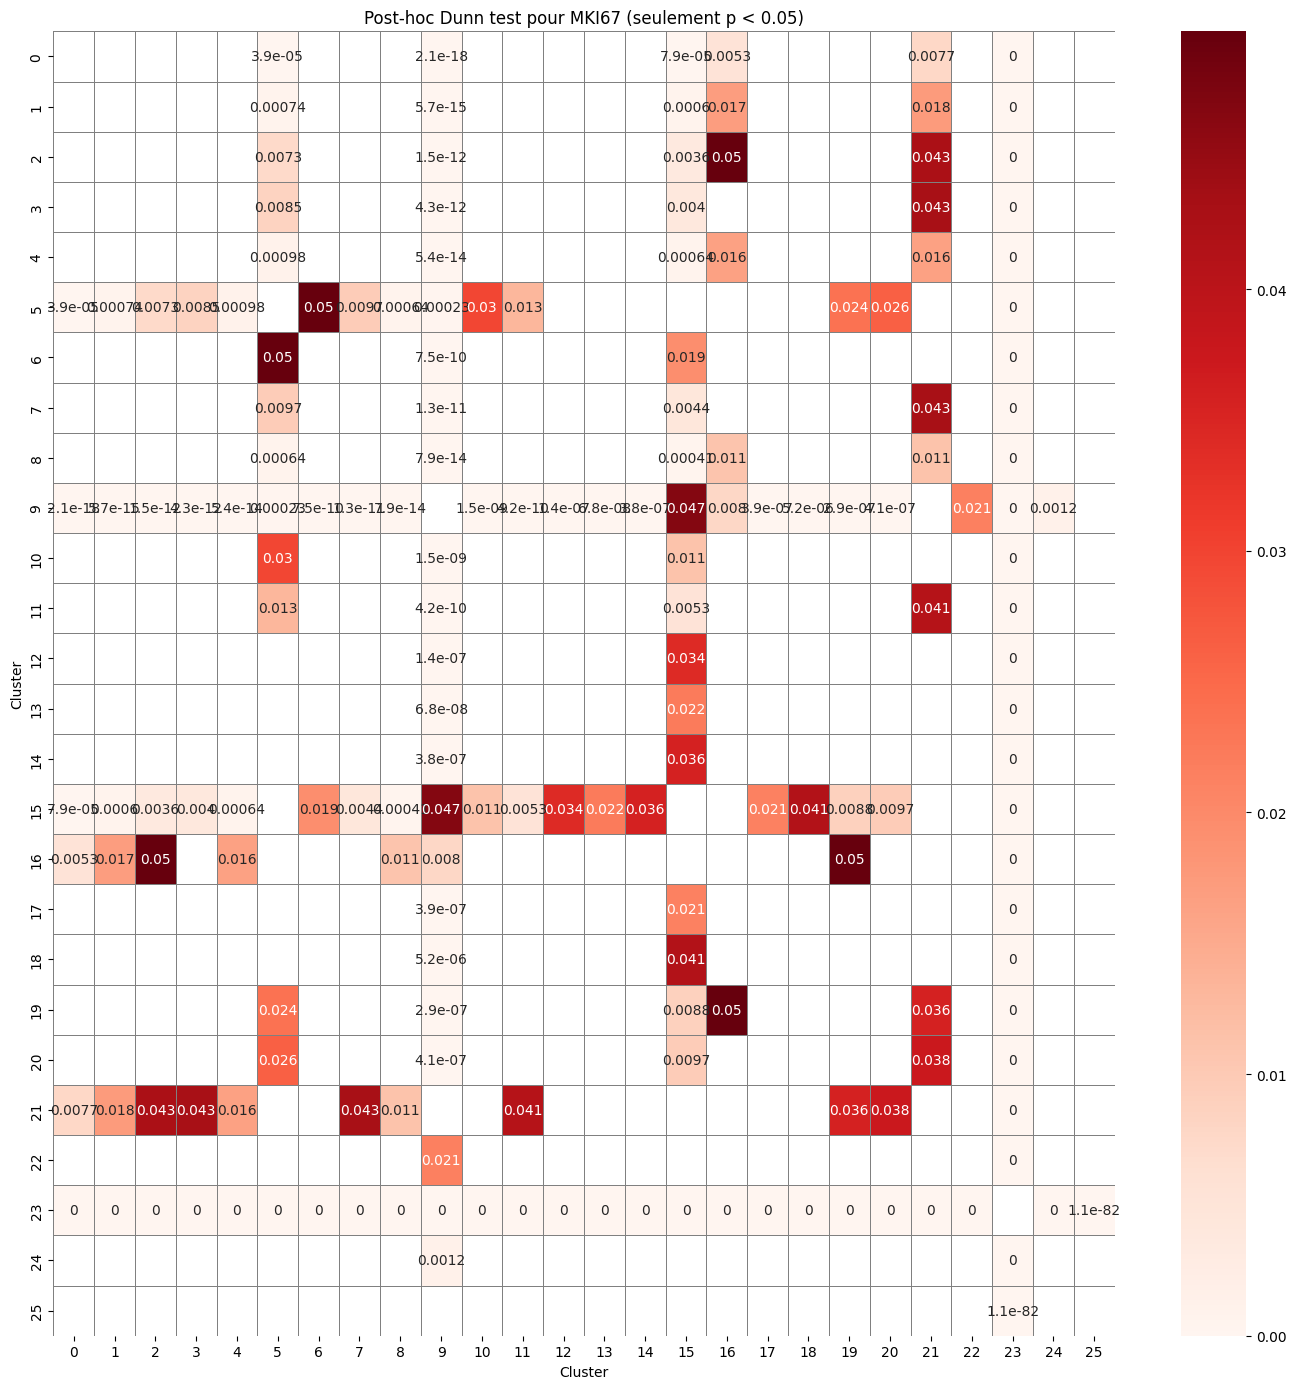

 Analyse pour le gène : IL1R1


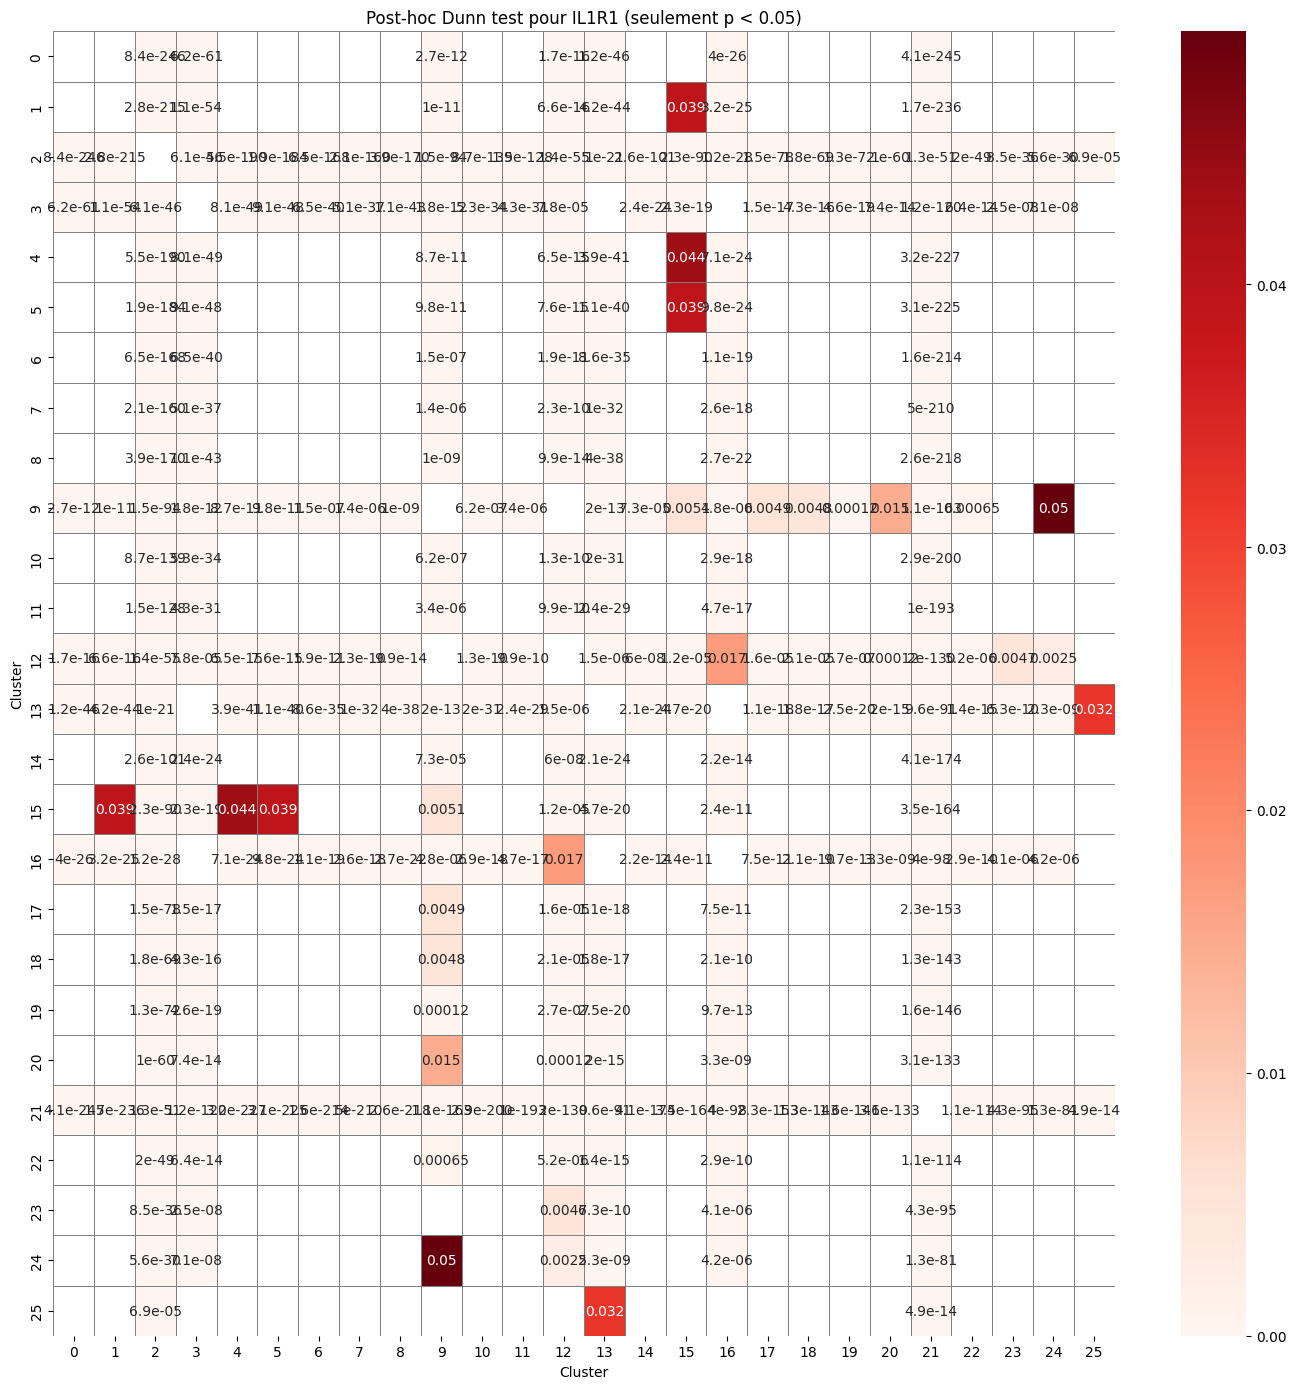

 Analyse pour le gène : IL1R2


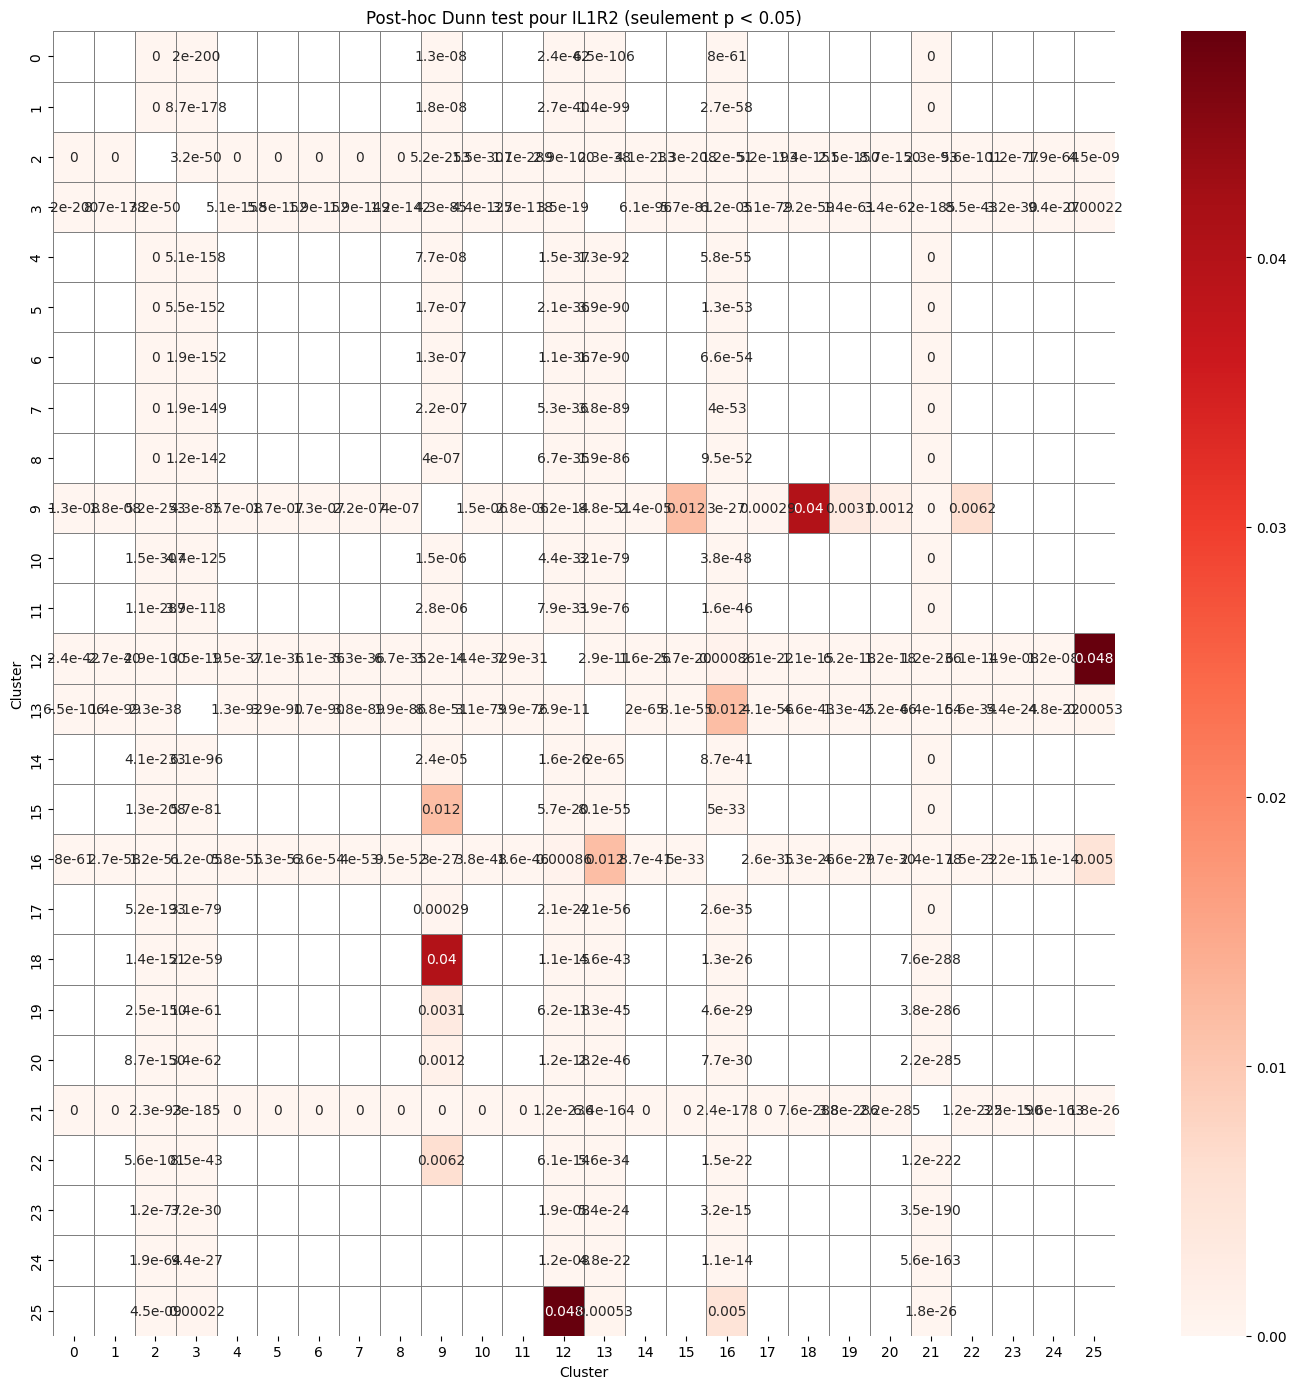

In [ ]:
genes_of_interest = ["CXCR5", "FOXP3", "PDCD1", "MKI67", "IL1R1", "IL1R2"]
plot_dunn_heatmaps_for_genes(adata_final, genes_of_interest)

**Test t par cluster : significativité des différences "1 vs tous"**

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

def one_vs_all_ttest(adata, gene, cluster_col="louvain"):
    """
    Performs a 1 vs all t-test for a given gene and returns p-values.

    Args:
        adata: AnnData object.
        gene: Gene name to test.
        cluster_col: Name of the column containing cluster labels.

    Returns:
        A pandas DataFrame with cluster labels as index and p-values as values.
    """

    clusters = adata.obs[cluster_col].unique()
    p_values = {}

    for cluster in clusters:
        # Extract expression data for the current cluster
        cluster_expr = adata[adata.obs[cluster_col] == cluster, gene].X.toarray().flatten()

        # Extract expression data for all other clusters
        rest_expr = adata[adata.obs[cluster_col] != cluster, gene].X.toarray().flatten()

        # Perform t-test
        t_stat, p_val = ttest_ind(cluster_expr, rest_expr)
        p_values[cluster] = p_val

    return pd.DataFrame({"p_value": p_values}, index=p_values.keys())

# Example usage (replace with your actual gene list and adata):
genes_of_interest = ["CXCR5", "FOXP3", "PDCD1", "MKI67", "IL1R1", "IL1R2"]
results = {}

for gene in genes_of_interest:
  results[gene] = one_vs_all_ttest(adata_final, gene)

# Display the results:
for gene, result in results.items():
    print(f"T-test results for gene: {gene}")
result


T-test results for gene: CXCR5
T-test results for gene: FOXP3
T-test results for gene: PDCD1
T-test results for gene: MKI67
T-test results for gene: IL1R1
T-test results for gene: IL1R2


p_value
14   5.079469e-13
7    7.662107e-26
1    5.049992e-37
10   4.321991e-19
6    5.635763e-27
11   1.790835e-17
8    8.092775e-24
4    5.971895e-29
17   4.515816e-10
20   1.161056e-07
23   5.470354e-03
9    1.444260e-03
22   2.113120e-05
15   1.238677e-06
5    1.147160e-26
12   1.445411e-13
13   5.354112e-60
25   2.618098e-01
19   3.265248e-07
16   5.780347e-26
24   7.963558e-03
18   6.227147e-06
0    1.091685e-51
3   1.412020e-142
2    0.000000e+00
21   0.000000e+00

**Identification de gènes plus exprimés dans chaque cluster (pas seulement les gènes d'interet) par méthode de wilcoxon**

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import warnings  # <- uyarılar için

def plot_top_genes_per_cluster(adata, groupby="louvain", n_genes=20, method="wilcoxon", key_added="rank_genes_groups", figsize=(20, 15)): #<- Change 'key_added' to 'rank_genes_groups'
    """
    Her bir cluster için istatistiksel olarak anlamlı en yüksek skorlu genleri gösteren grafik üretir.
    Uyarılar bastırılmıştır (fragmentation vs.).
    """

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # nouveau DataFrame
        adata.uns[key_added] = {}
        adata.uns[key_added] = adata.uns.get(key_added, {}).copy()

        # Differential expression analysis
        sc.tl.rank_genes_groups(
            adata,
            groupby=groupby,
            method=method,
            key_added=key_added #<- 'key_added' will store the results under the key 'rank_genes_groups'
        )

    # Graph
    sc.pl.rank_genes_groups(
        adata,
        n_genes=n_genes,
        key=key_added,
        sharey=False,
        figsize=figsize
    )


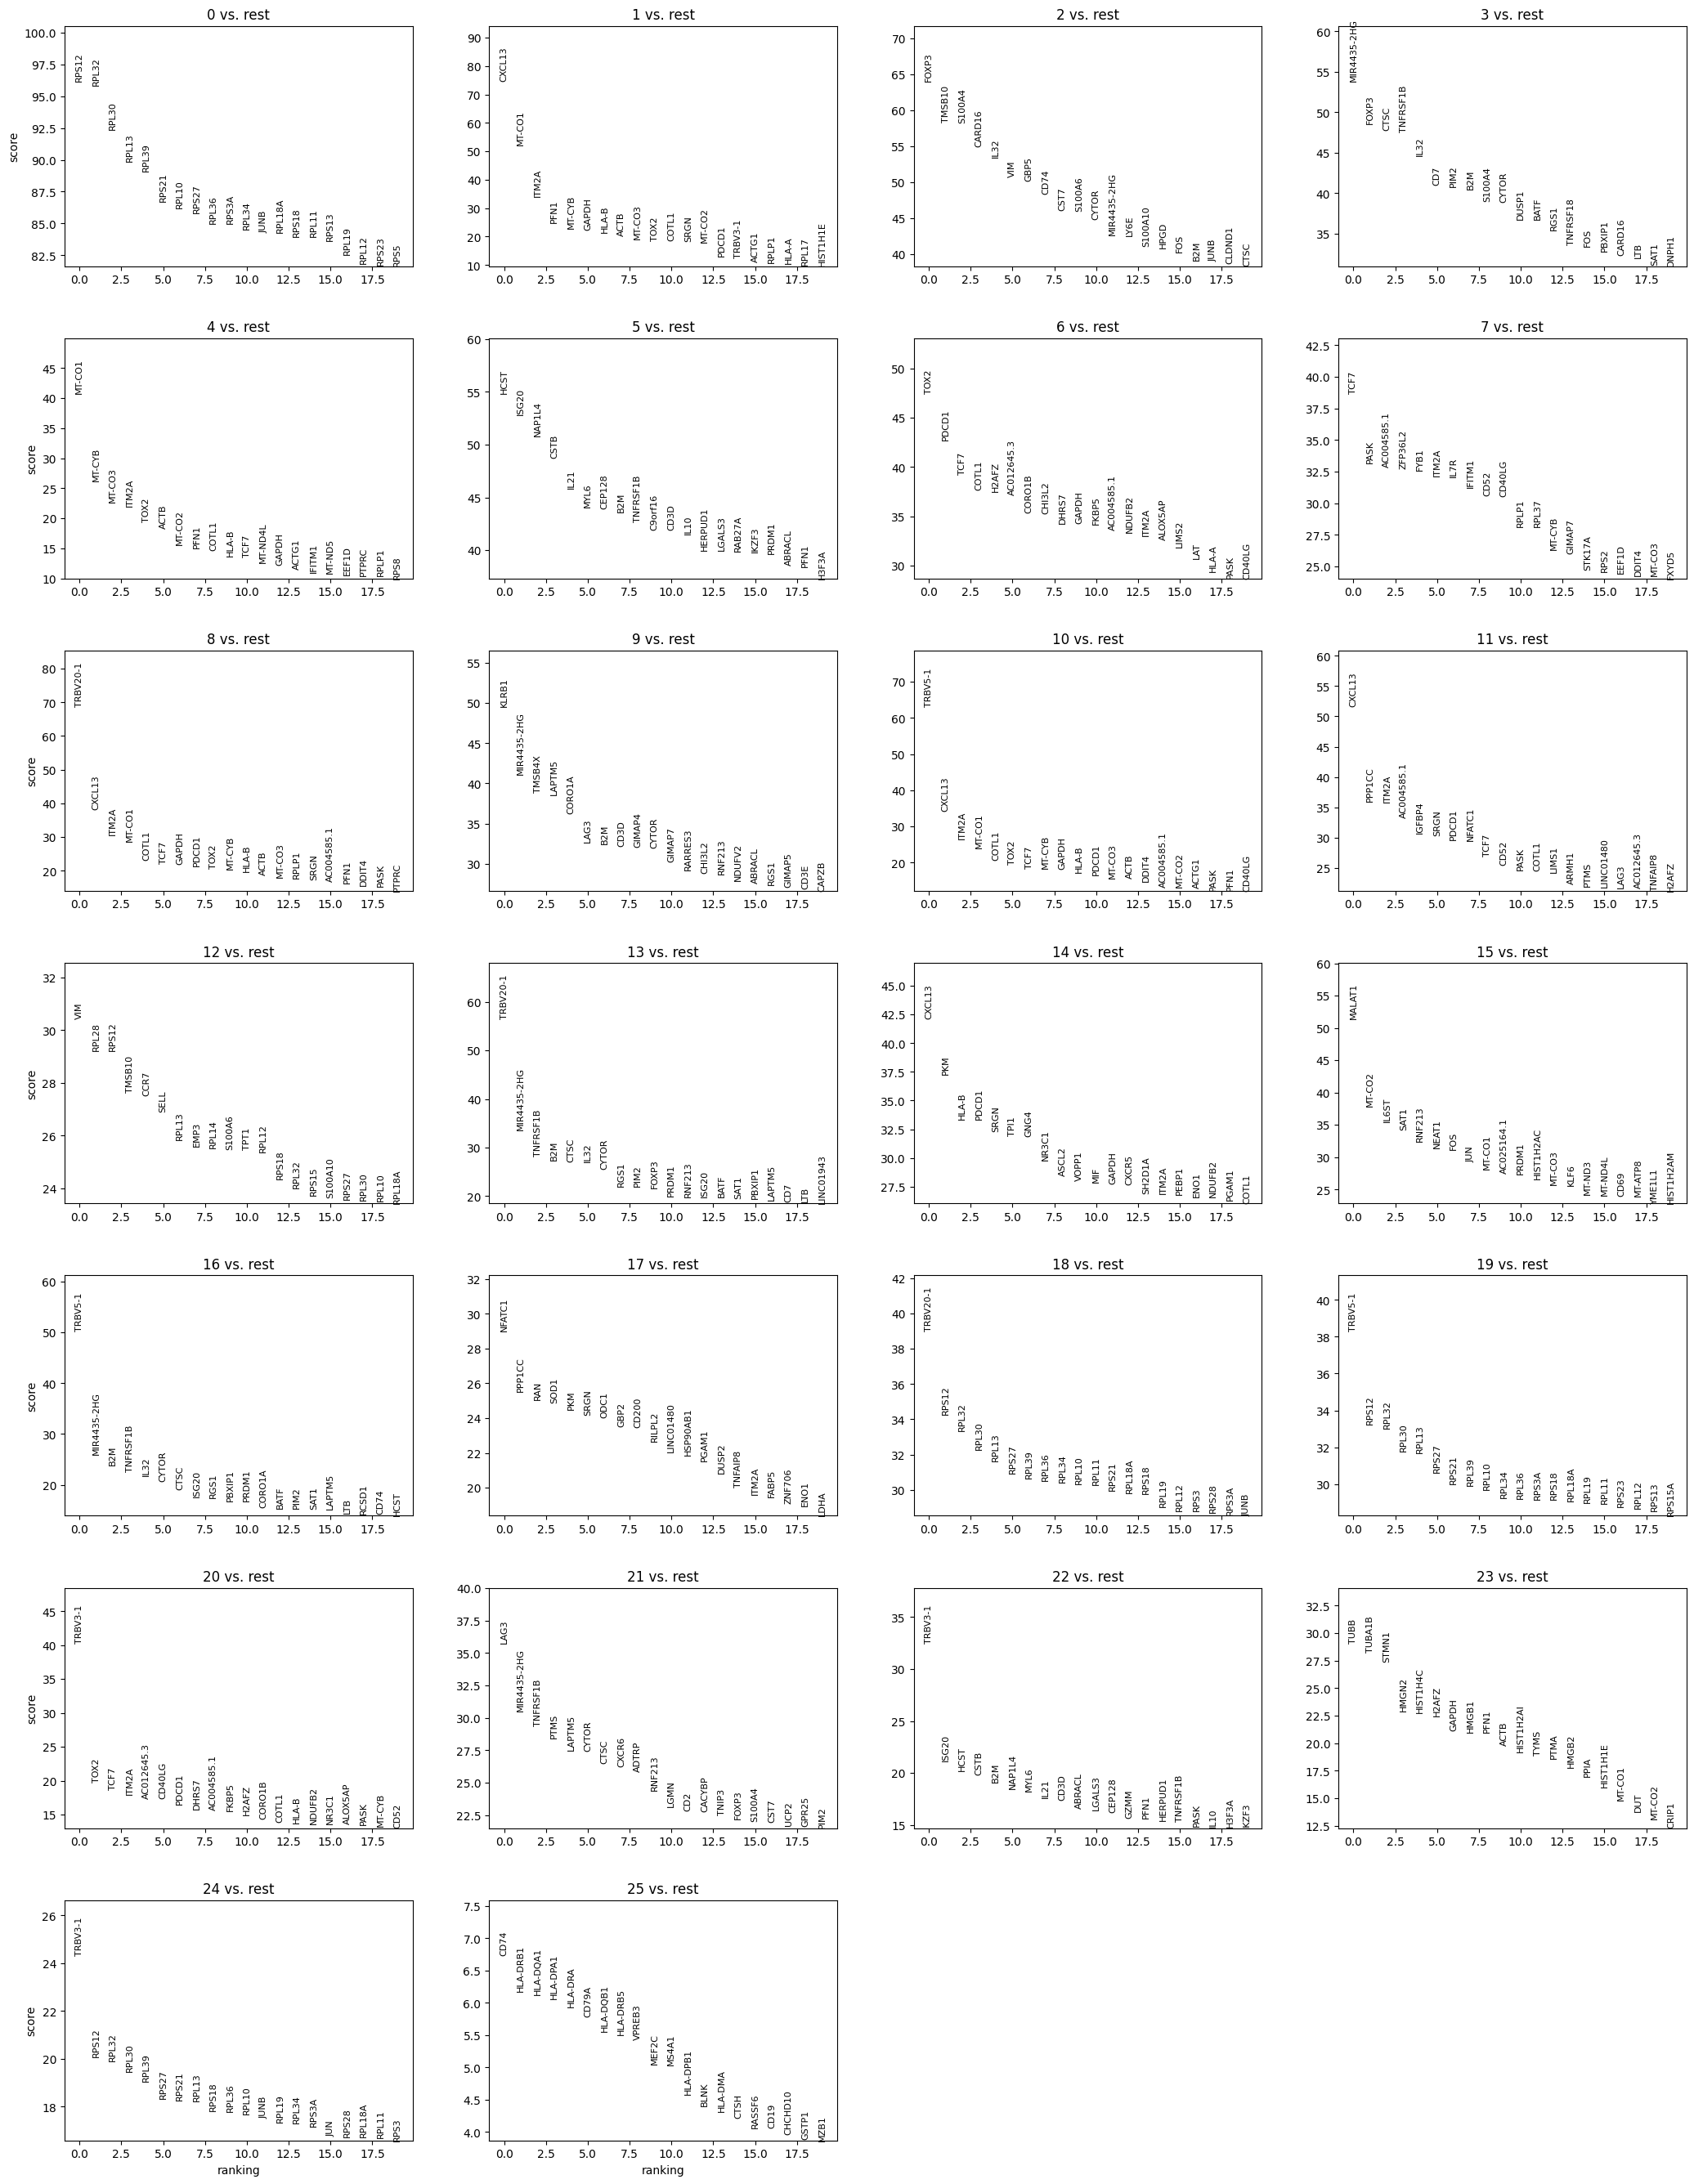

In [ ]:
plot_top_genes_per_cluster(adata_final)

**Enrichissement Fonctionelle pour associer chaque cluster è une voie biologique en fonction de gènes exprimès**

In [ ]:
import pandas as pd
import gseapy as gp
#from gseapy.plot import barplot # This import is not used
from IPython.display import display
import time

def functional_enrichment_from_top_genes(adata, gene_set_library='GO_Biological_Process_2021', n_genes=20, groupby='louvain', key_added='rank_genes_groups'):  # <- Add key_added parameter
    """
    Her cluster için .uns['rank_genes_groups'] içinden en yüksek skorlu genlerle enrichissement fonksiyonel analizi yapar.

    Parameters:
        adata : AnnData object
        gene_set_library : enrichr kütüphanesi ismi (örnek: 'GO_Biological_Process_2021')
        n_genes : her cluster için analizde kullanılacak gen sayısı
        groupby : cluster etiket kolonu (varsayılan: 'louvain')
        key_added: sc.tl.rank_genes_groups tarafından kullanılan key_added parametresi. # <- New parameter description
    Returns:
        pd.DataFrame : her cluster için enrich edilmiş yollar ve kullanılan genler
    """
    clusters = adata.obs[groupby].unique().tolist()
    all_results = []

    #  enrich yap
    for cl in clusters:
        # Top n_genes , key_added parametre
        top_genes = adata.uns[key_added]['names'][cl][:n_genes]  # <- Use key_added here
        top_genes = [g for g in top_genes if g is not None]

        #print(f"Cluster {cl}: Top genes - {top_genes[:5]} (and {len(top_genes) - 5} more)")

        time.sleep(5)

        try:
            enr = gp.enrichr(gene_list=top_genes,
                             gene_sets=gene_set_library,
                             organism='Human',
                             outdir=None,
                             verbose=False)
        except Exception as e:
            print(f"Error processing cluster {cl}: {e}")
            continue

        # Check if enr.res2d is not None and not empty before proceeding.
        if enr.res2d is not None and not enr.res2d.empty:
            top_pathway = enr.res2d.sort_values('Adjusted P-value').iloc[0]
            all_results.append({
                'Cluster': cl,
                'Top_genes': ', '.join(top_genes),
                'Pathway': top_pathway['Term'],
                'P-value': top_pathway['Adjusted P-value']
            })
        else:
            all_results.append({
                'Cluster': cl,
                'Top_genes': ', '.join(top_genes),
                'Pathway': 'No enrichment',
                'P-value': None
            })

    results_df = pd.DataFrame(all_results)
    # Return an empty DataFrame if all_results is empty to avoid returning None
    if results_df.empty:
        return pd.DataFrame(columns=['Cluster', 'Top_genes', 'Pathway', 'P-value'])

    results_df = results_df.sort_values(by="Cluster").reset_index(drop=True)
    display(results_df)
    return results_df #<- Explicitly return the DataFrame

In [ ]:
enrichment_df = functional_enrichment_from_top_genes(
    adata=adata_final,
    gene_set_library='GO_Biological_Process_2021',
    n_genes=20,
    groupby='louvain',
    key_added='rank_genes_groups'
)

Cluster                                          Top_genes  \
0        0  RPS12, RPL32, RPL30, RPL13, RPL39, RPS21, RPL1...   
1        1  CXCL13, MT-CO1, ITM2A, PFN1, MT-CYB, GAPDH, HL...   
2       10  TRBV5-1, CXCL13, ITM2A, MT-CO1, COTL1, TOX2, T...   
3       11  CXCL13, PPP1CC, ITM2A, AC004585.1, IGFBP4, SRG...   
4       12  VIM, RPL28, RPS12, TMSB10, CCR7, SELL, RPL13, ...   
5       13  TRBV20-1, MIR4435-2HG, TNFRSF1B, B2M, CTSC, IL...   
6       14  CXCL13, PKM, HLA-B, PDCD1, SRGN, TPI1, GNG4, N...   
7       15  MALAT1, MT-CO2, IL6ST, SAT1, RNF213, NEAT1, FO...   
8       16  TRBV5-1, MIR4435-2HG, B2M, TNFRSF1B, IL32, CYT...   
9       17  NFATC1, PPP1CC, RAN, SOD1, PKM, SRGN, ODC1, GB...   
10      18  TRBV20-1, RPS12, RPL32, RPL30, RPL13, RPS27, R...   
11      19  TRBV5-1, RPS12, RPL32, RPL30, RPL13, RPS27, RP...   
12       2  FOXP3, TMSB10, S100A4, CARD16, IL32, VIM, GBP5...   
13      20  TRBV3-1, TOX2, TCF7, ITM2A, AC012645.3, CD40LG...   
14      21  LAG3, MIR4435-2HG, TNFRSF1B, PTMS, LAPTM5, CYT...   
15      22  TRBV3-1, ISG20, HCST, CSTB, B2M, NAP1L4, MYL6,...   
16      23  TUBB, TUBA1B, STMN1, HMGN2, HIST1H4C, H2AFZ, G...   
17      24  TRBV3-1, RPS12, RPL32, RPL30, RPL39, RPS27, RP...   
18      25  CD74, HLA-DRB1, HLA-DQA1, HLA-DPA1, HLA-DRA, C...   
19       3  MIR4435-2HG, FOXP3, CTSC, TNFRSF1B, IL32, CD7,...   
20       4  MT-CO1, MT-CYB, MT-CO3, ITM2A, TOX2, ACTB, MT-...   
21       5  HCST, ISG20, NAP1L4, CSTB, IL21, MYL6, CEP128,...   
22       6  TOX2, PDCD1, TCF7, COTL1, H2AFZ, AC012645.3, C...   
23       7  TCF7, PASK, AC004585.1, ZFP36L2, FYB1, ITM2A, ...   
24       8  TRBV20-1, CXCL13, ITM2A, MT-CO1, COTL1, TCF7, ...   
25       9  KLRB1, MIR4435-2HG, TMSB4X, LAPTM5, CORO1A, LA...   

                                              Pathway       P-value  
0   SRP-dependent cotranslational protein targetin...  4.960800e-43  
1   protection from natural killer cell mediated c...  1.349009e-03  
2          regulation of immune response (GO:0050776)  7.443736e-03  
3          regulation of immune response (GO:0050776)  6.870676e-02  
4   SRP-dependent cotranslational protein targetin...  4.991603e-22  
5   regulation of T cell cytokine production (GO:0...  2.501395e-04  
6   glucose catabolic process to pyruvate (GO:0061...  2.837660e-09  
7       cellular response to cadmium ion (GO:0071276)  2.300445e-02  
8    cytokine-mediated signaling pathway (GO:0019221)  5.857735e-03  
9                     glycolytic process (GO:0006096)  6.455959e-06  
10  SRP-dependent cotranslational protein targetin...  2.026718e-39  
11  SRP-dependent cotranslational protein targetin...  4.849321e-43  
12                    zymogen inhibition (GO:0097341)  3.499145e-03  
13         regulation of immune response (GO:0050776)  6.074252e-02  
14       regulation of T cell activation (GO:0050863)  4.352380e-03  
15  regulation of lymphocyte proliferation (GO:005...  1.821180e-04  
16  pyrimidine deoxyribonucleotide biosynthetic pr...  3.518110e-03  
17  SRP-dependent cotranslational protein targetin...  3.749451e-36  
18  antigen receptor-mediated signaling pathway (G...  1.426544e-17  
19  regulation of T cell cytokine production (GO:0...  2.382123e-04  
20  morphogenesis of a polarized epithelium (GO:00...  1.504431e-02  
21  regulation of lymphocyte proliferation (GO:005...  1.901330e-04  
22         regulation of immune response (GO:0050776)  5.722703e-02  
23                           translation (GO:0006412)  5.840522e-03  
24     regulation of cytokine production (GO:0001817)  4.774624e-03  
25         regulation of immune response (GO:0050776)  1.849586e-04

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

def plot_umap_and_separate_legend(
    adata,
    cluster_role_df,
    cluster_key="louvain",
    role_col="Pathway",
    umap_title="UMAP coloré par rôles des clusters",
    legend_title="Légende des rôles"
):
    # Cluster
    role_df = cluster_role_df.copy()
    role_df["Cluster"] = role_df["Cluster"].astype(str)
    role_dict = role_df.set_index("Cluster")[role_col].to_dict()
    adata.obs["roles"] = adata.obs[cluster_key].astype(str).map(role_dict)
    adata.obs["roles"] = adata.obs["roles"].fillna("aucun rôle significatif")

    # Convert 'roles' column to categorical
    adata.obs["roles"] = pd.Categorical(adata.obs["roles"]) #<- This line converts the 'roles' column into a categorical data type

    # Couleurs
    unique_roles = adata.obs["roles"].unique().tolist()
    role_colors = dict(zip(unique_roles, sc.pl.palettes.default_102[:len(unique_roles)]))
    adata.uns["roles_colors"] = [role_colors[role] for role in adata.obs["roles"].cat.categories]

    # 1. UMAP
    sc.pl.umap(
        adata,
        color="roles",
        title=umap_title,
        legend_loc=None,  # legend olmadan
        size=30,
        frameon=False
    )

    # 2. Legends
    fig, ax = plt.subplots(figsize=(5, len(unique_roles) * 0.3 + 1))
    handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   label=role, markerfacecolor=color, markersize=8)
        for role, color in role_colors.items()
    ]
    ax.legend(handles=handles, loc='center', frameon=False, title=legend_title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


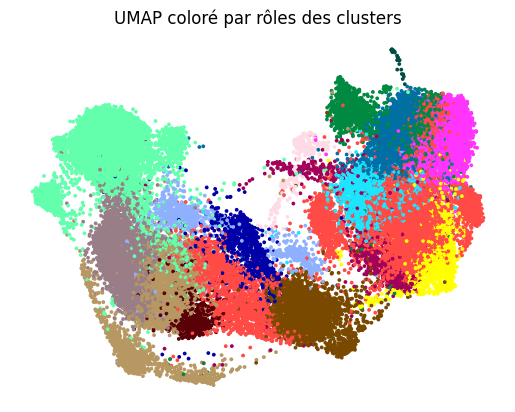

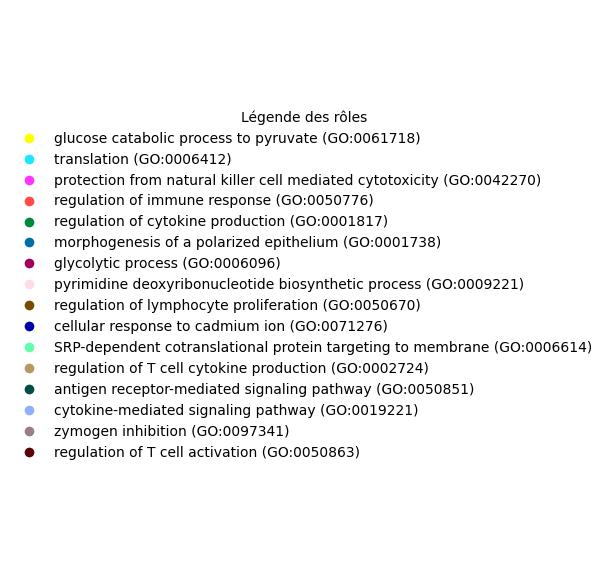

In [ ]:
plot_umap_and_separate_legend(adata_final, enrichment_df)

**DIFFERENCIATION CELLULAIRE DES QUATRE TYPES CELLULAIRES**

Calcul des voisins...
Calcul UMAP...


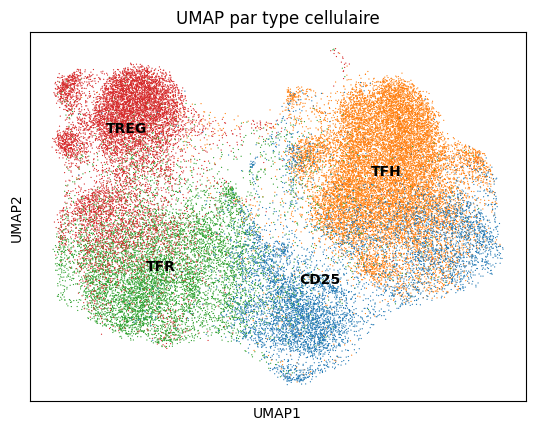

Calcul PAGA...


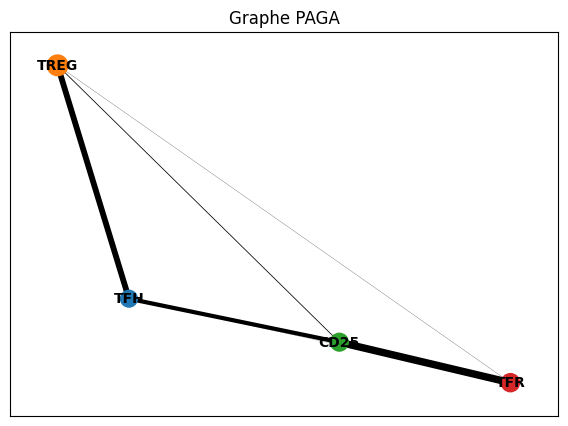

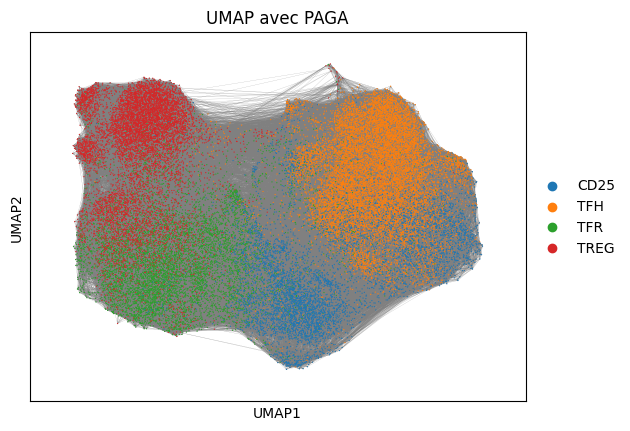

Calcul DPT pour chaque type cellulaire...


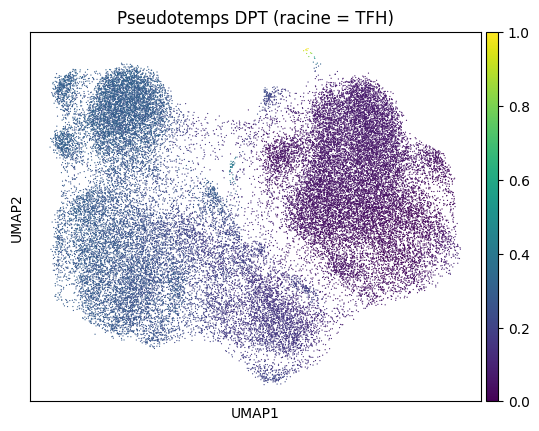

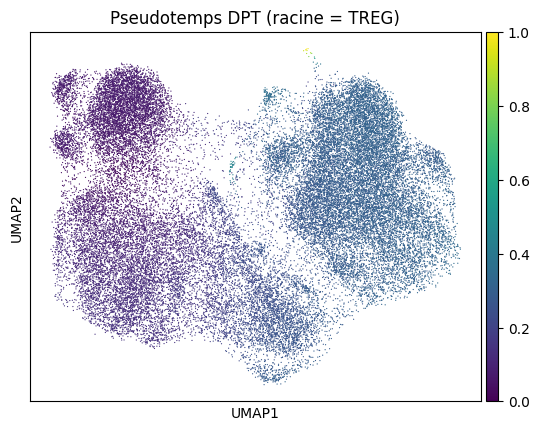

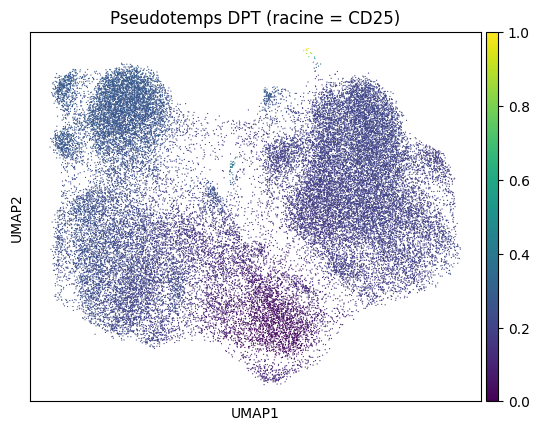

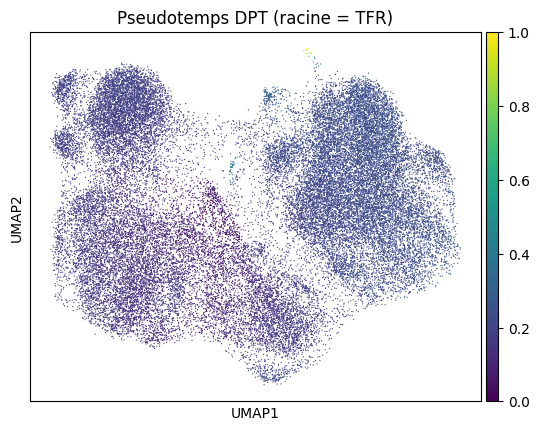

Analyse dynamique avec scVelo...
Couches 'spliced/unspliced' absentes, scVelo non lancé.
Analyse complète.


In [ ]:
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Configuration de base ---
annotation_column = 'sample_id'  # Nom de la colonne contenant les types cellulaires
cell_types_of_interest = ['TFH', 'TREG', 'CD25', 'TFR']

# Vérification que la colonne d’annotation existe
if annotation_column not in adata_final.obs.columns:
    print(f"Erreur : colonne '{annotation_column}' absente.")
    exit()

# Avertir si certains types cellulaires sont manquants
for ct in cell_types_of_interest:
    if ct not in adata_final.obs[annotation_column].unique():
        print(f"Avertissement : '{ct}' non trouvé dans les annotations.")

# --- Graphe des voisins ---
print("Calcul des voisins...")
sc.pp.neighbors(adata_final)

# --- UMAP ---
print("Calcul UMAP...")
sc.tl.umap(adata_final)
# Forcer le type 'category' pour la coloration
adata_final.obs[annotation_column] = adata_final.obs[annotation_column].astype('category')
# Affichage
sc.pl.umap(adata_final, color=annotation_column, title='UMAP par type cellulaire', legend_loc='on data', groups=cell_types_of_interest)
plt.show()

# --- Graphe PAGA ---
print("Calcul PAGA...")
sc.tl.paga(adata_final, groups=annotation_column)
sc.pl.paga(adata_final, color=[annotation_column], title='Graphe PAGA', groups=cell_types_of_interest)
plt.show()

# UMAP avec arêtes PAGA
sc.pl.umap(adata_final, color=annotation_column, edges=True, title='UMAP avec PAGA', groups=cell_types_of_interest)
plt.show()

# --- Pseudotemps DPT pour chaque type cellulaire ---
print("Calcul DPT pour chaque type cellulaire...")
for root_type in cell_types_of_interest:
    root_cells = adata_final.obs_names[adata_final.obs[annotation_column] == root_type].tolist()
    if root_cells:
        adata_final.uns['iroot'] = adata_final.obs_names.get_loc(root_cells[0])
        sc.tl.dpt(adata_final, n_dcs=10)
        sc.pl.umap(adata_final, color='dpt_pseudotime', title=f'Pseudotemps DPT (racine = {root_type})', groups=cell_types_of_interest)
        plt.show()
    else:
        print(f"Avertissement : aucune cellule '{root_type}' pour initier DPT.")

# --- Vélocité (scVelo) ---
print("Analyse dynamique avec scVelo...")
if 'spliced' in adata_final.layers and 'unspliced' in adata_final.layers:
    scv.pp.filter_and_normalize(adata_final, min_shared_counts=20)
    scv.pp.moments(adata_final, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata_final, mode='stochastic')
    scv.tl.velocity_graph(adata_final)

    # Flux de vélocité
    scv.pl.velocity_embedding_stream(adata_final, basis='umap', color=annotation_column, title='Flux de vélocité', legend_loc='right', groups=cell_types_of_interest)
    plt.show()

    # États terminaux
    scv.tl.terminal_states(adata_final, groups=annotation_column, vkey='velocity_umap')
    scv.pl.umap(adata_final, color='terminal_states', title='États terminaux', groups=cell_types_of_interest)
    plt.show()

    # Gènes dynamiques
    try:
        scv.tl.rank_genes(adata_final, groupby=annotation_column, vkey='velocity_pseudotime', mode='stochastic')
        scv.pl.rank_genes(adata_final, groupby=annotation_column, vkey='velocity_pseudotime', n_genes=20, fontsize=8, groups=cell_types_of_interest)
        plt.show()
    except KeyError:
        print("Pseudotemps de vélocité non disponible.")
else:
    print("Couches 'spliced/unspliced' absentes, scVelo non lancé.")

# --- Fin de l’analyse ---
print("Analyse complète.")

**MODELE DE MACHINE LEARNING POUR PREDIRE LE TYPE DE CELLULE POUR CHAQUE CLUSTER**

In [ ]:
# --- Import des bibliothèques ---
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# --- Paramètres globaux ---
CLUSTER_KEY = 'louvain'  # Clé du clustering Louvain existant
TRUE_CELL_TYPE_COL = 'sample_id'  # Colonne avec les vrais types cellulaires

In [ ]:
# --- Préparation des données ---
def prepare_data(adata, true_label_col):
    """Préparer les données X, y à partir des cellules avec des types connus."""
    known_mask = ~adata.obs[true_label_col].isnull()
    adata_known = adata[known_mask].copy()
    adata_known.obs_names_make_unique()

    X_known = adata_known.X
    labels_known = adata_known.obs[true_label_col]

    label_encoder = LabelEncoder()
    y_known = label_encoder.fit_transform(labels_known)

    return X_known, y_known, label_encoder, adata_known

In [ ]:
# --- Execution ---
X_known, y_known, label_encoder, adata_known = prepare_data(adata_final, TRUE_CELL_TYPE_COL)
print(f"✅ {X_known.shape[0]} cellules connues extraites.")

✅ 38484 cellules connues extraites.


In [ ]:
# --- Séparation train/test ---
def split_data(X_known, y_known, obs_names):
    """Diviser les données en jeu d'entraînement et de test."""
    return train_test_split(
        X_known, y_known, obs_names, test_size=0.2, random_state=0, stratify=y_known
    )


In [ ]:
# --- Execution ---
X_train, X_test, y_train, y_test, idx_train, idx_test = split_data(X_known, y_known, adata_known.obs_names)
print(f"✅ Split effectué : {X_train.shape[0]} en train, {X_test.shape[0]} en test.")

✅ Split effectué : 30787 en train, 7697 en test.


In [ ]:
# --- Entraînement du modèle ---
def train_random_forest(X_train, y_train):
    """Entraîner un Random Forest."""
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X_train, y_train)
    return rf

In [ ]:
# --- Execution ---
rf_model = train_random_forest(X_train, y_train)
print("✅ Modèle Random Forest entraîné.")

✅ Modèle Random Forest entraîné.


In [ ]:
# --- Évaluation du modèle ---
def evaluate_model(rf, X_test, y_test, label_encoder):
    """Évaluer le modèle sur le jeu de test."""
    y_pred = rf.predict(X_test)
    labels = label_encoder.classes_

    print("→ Accuracy :", accuracy_score(y_test, y_pred))
    print("\n→ Rapport de classification :\n", classification_report(y_test, y_pred, target_names=labels))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prédit')
    plt.ylabel('Vrai')
    plt.title('Matrice de Confusion')
    plt.show()

→ Accuracy : 0.8507210601533065

→ Rapport de classification :
               precision    recall  f1-score   support

        CD25       0.87      0.66      0.75      1292
         TFH       0.86      0.98      0.92      2973
         TFR       0.76      0.82      0.79      1653
        TREG       0.91      0.81      0.86      1779

    accuracy                           0.85      7697
   macro avg       0.85      0.82      0.83      7697
weighted avg       0.85      0.85      0.85      7697



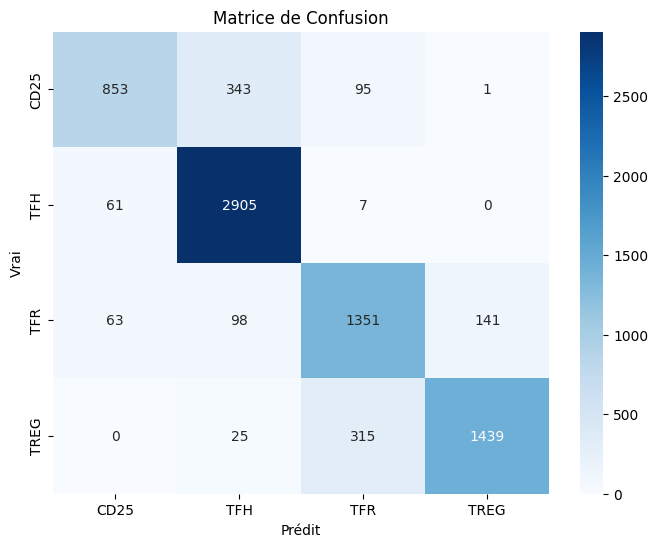

In [ ]:
# --- Execution ---
evaluate_model(rf_model, X_test, y_test, label_encoder)

In [ ]:
# --- Prédictions sur jeu de test ---
def predict_test_cells(rf, adata_test, label_encoder, X_test):
    """Prédire les types cellulaires uniquement pour les cellules du jeu de test."""
    pred_labels_encoded = rf.predict(X_test)
    pred_labels = label_encoder.inverse_transform(pred_labels_encoded)
    adata_test.obs['predicted_label'] = pd.Categorical(pred_labels)

In [ ]:
# --- Execution ---
adata_test = adata_known[idx_test].copy()
adata_test.obs['true_label'] = pd.Categorical(label_encoder.inverse_transform(y_test))
predict_test_cells(rf_model, adata_test, label_encoder, X_test)
print("✅ Prédictions effectuées sur le test set.")

✅ Prédictions effectuées sur le test set.


In [ ]:
# --- Analyse majoritaire par cluster ---
def assign_major_type_per_cluster_test(adata_test, cluster_key):
    """Définir pour chaque cluster du test set son type majoritaire."""
    cluster_type_pred = adata_test.obs.groupby(cluster_key)['predicted_label'].apply(
        lambda x: Counter(x).most_common(1)[0][0]
    ).reset_index()

    cluster_type_pred.columns = [cluster_key, 'predicted_major_cell_type_test']
    adata_test.obs = adata_test.obs.merge(cluster_type_pred, on=cluster_key, how='left')

    print("\n→ Types cellulaires majoritaires par cluster (test set) :")
    print(cluster_type_pred)

In [ ]:
# --- Execution ---
assign_major_type_per_cluster_test(adata_test, CLUSTER_KEY)


→ Types cellulaires majoritaires par cluster (test set) :
   louvain predicted_major_cell_type_test
0        0                           TREG
1        1                            TFH
2        2                            TFR
3        3                            TFR
4        4                            TFH
5        5                           CD25
6        6                            TFH
7        7                            TFH
8        8                            TFH
9        9                            TFR
10      10                            TFH
11      11                            TFH
12      12                           TREG
13      13                            TFR
14      14                           CD25
15      15                            TFR
16      16                            TFR
17      17                            TFH
18      18                           TREG
19      19                           TREG
20      20                            TFH
21      21       

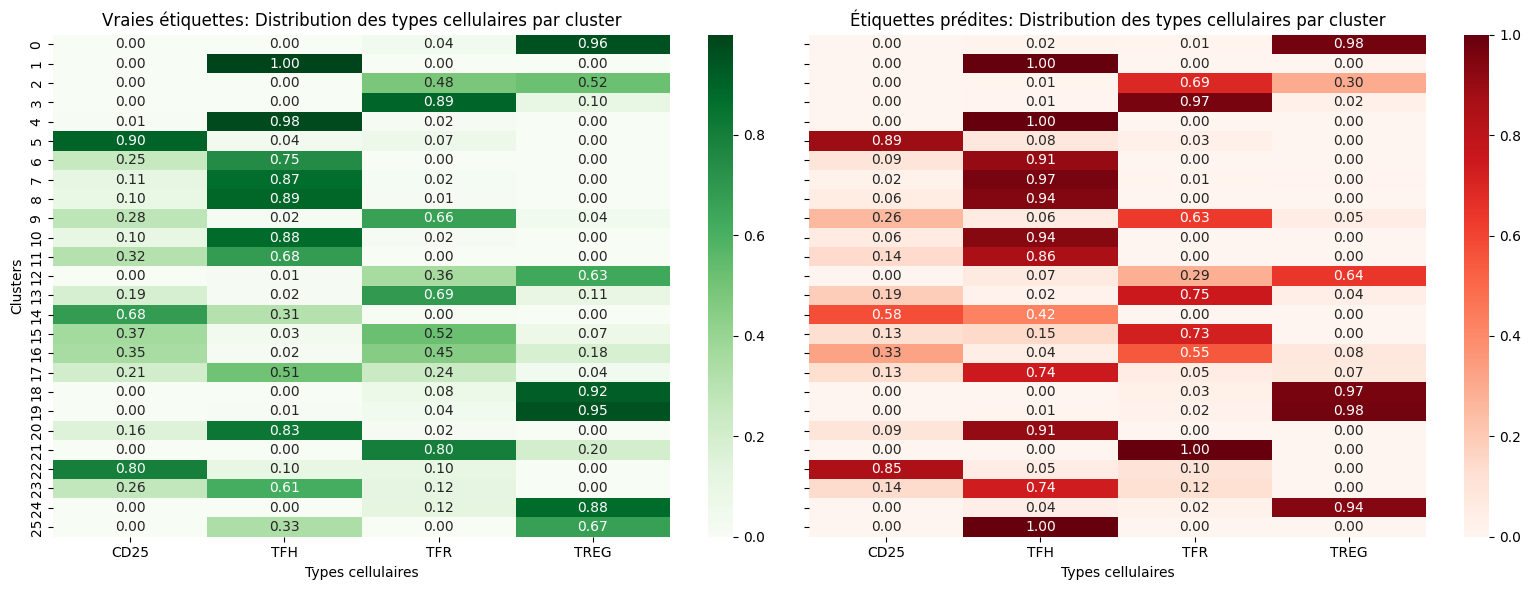

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster key
cluster_key = CLUSTER_KEY  # Örneğin: 'louvain'

# Gerçek ve tahmin edilen etiketleri içeren test seti
adata_test.obs['true_label'] = pd.Categorical(label_encoder.inverse_transform(y_test))
adata_test.obs['predicted_label'] = pd.Categorical(rf_model.predict(X_test), categories=label_encoder.transform(label_encoder.classes_))
adata_test.obs['predicted_label'] = pd.Categorical(label_encoder.inverse_transform(adata_test.obs['predicted_label']))

# --- Gerçek etiketlerin dağılımı ---
true_distribution = (
    adata_test.obs.groupby([cluster_key, 'true_label'])
    .size()
    .unstack(fill_value=0)
    .div(adata_test.obs.groupby(cluster_key).size(), axis=0)
)

# --- Tahmin edilen etiketlerin dağılımı ---
predicted_distribution = (
    adata_test.obs.groupby([cluster_key, 'predicted_label'])
    .size()
    .unstack(fill_value=0)
    .div(adata_test.obs.groupby(cluster_key).size(), axis=0)
)

# --- Görselleştirme ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.heatmap(true_distribution, ax=axes[0], cmap="Greens", annot=True, fmt=".2f")
axes[0].set_title("Vraies étiquettes: Distribution des types cellulaires par cluster")
axes[0].set_xlabel("Types cellulaires")
axes[0].set_ylabel("Clusters")

sns.heatmap(predicted_distribution, ax=axes[1], cmap="Reds", annot=True, fmt=".2f")
axes[1].set_title("Étiquettes prédites: Distribution des types cellulaires par cluster")
axes[1].set_xlabel("Types cellulaires")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()